<a href="https://colab.research.google.com/github/wandb/examples/blob/master/colabs/boosting/Credit_Scorecards_with_XGBoost_and_W&B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
<!--- @wandbcode{xgboost_vehicle_loan_default} -->

<img src="http://wandb.me/logo-im-png" width="400" alt="Weights & Biases" /><br>

<!--- @wandbcode{xgboost_vehicle_loan_default} -->

<img src="http://wandb.me/mini-diagram" width="600" alt="Weights & Biases" />

# In this notebook

In this colab we'll cover how Weights and Biases enables regulated entities to
- **Track and version** their data ETL pipelines (locally or in cloud services such as S3 and GCS)
- **Track experiment results** and store trained models
- **Visually inspect** multiple evaluation metrics
- **Optimize performance** with hyperparameter sweeps

# Setup

In [1]:
import wandb
from pathlib import Path
import numpy as np
import sys
import os
import pandas as pd
from sklearn import model_selection
import xgboost as xgb


## Login to W&B
Login to Weights and Biases

In [2]:
import wandb

WANDB_PROJECT ='titanic_survived'
os.environ['WANDB_NOTEBOOK_NAME'] = 'Titanic_Survived_with_XGBoost.ipynb'

In [3]:
wandb.login()

wandb: Currently logged in as: max-deep. Use `wandb login --relogin` to force relogin


True

#### Upload Data with W&B Artifacts

In [6]:
run = wandb.init(project=WANDB_PROJECT, job_type='add-dataset')

Download the subset of the vehicle loan default data from W&B, this contains `train.csv` and `val.csv` files as well as some utils files.

In [7]:
artifact = wandb.Artifact(name="titanic-dataset", type="dataset")
artifact.add_dir(local_path="./titanic")  # Add dataset directory to artifact
run.log_artifact(artifact)

wandb: Adding directory to artifact (.\titanic)... Done. 0.1s


<Artifact titanic-dataset>

In [8]:
run.finish()

## Get Train/Validation Split

Here we show an alternative pattern for how to create a wandb run object. In the cell below, the code to split the dataset is wrapped with a call to `wandb.init() as run`.

Here we will:

- Start a wandb run
- Download our one-hot-encoded dataset from Artifacts
- Do the Train/Val split and log the params used in the split
- Log the new `trndat` and `valdat` datasets to Artifacts
- Finish the wandb run automatically

In [12]:
target = 'Survived'

In [14]:
with wandb.init(project=WANDB_PROJECT, job_type='train-val-split') as run:     # config is optional here

    # Download the subset of the vehicle loan default data from W&B
    dataset_art = run.use_artifact('max-deep/titanic_survived/titanic-dataset:v0', type='dataset')
    root_dir = Path(sys.path[0])  # get this notebook path
    data_dir = root_dir / 'dataset'
    data_dir.mkdir(exist_ok=True)
    
    dataset_dir = dataset_art.download(data_dir)
    dataset = pd.read_csv(f'{data_dir}/train.csv')

    # Set Split Params
    test_size = 0.20
    random_state = 42

    # Log the splilt params
    run.config.update({'test_size':test_size, 'random_state': random_state})

    # Do the Train/Val Split
    trndat, valdat = model_selection.train_test_split(dataset, test_size=test_size,
                                                      random_state=random_state, stratify=dataset[[target]])

    print(f'Train dataset size: {trndat[target].value_counts()} \n')
    print(f'Validation dataset sizeL {valdat[target].value_counts()}')

    # Save split datasets
    data_split_dir = root_dir / 'split-dataset'
    data_split_dir.mkdir(exist_ok=True)
    train_path = data_split_dir/'train.csv'
    val_path = data_split_dir/'val.csv'
    trndat.to_csv(train_path, index=False)
    valdat.to_csv(val_path, index=False)

    # Create a new artifact for the processed data, including the function that created it, to Artifacts
    split_ds_art = wandb.Artifact(name='titanic-dataset-split',
                                        type='train-val-dataset',
                                        description='Processed dataset split into training and validation sets',
                                        metadata={'test_size': test_size, 'random_state': random_state}
                                     )

    # Attach our processed data to the Artifact
    split_ds_art.add_file(train_path)
    split_ds_art.add_file(val_path)

    # Log the Artifact
    run.log_artifact(split_ds_art)

wandb:   3 of 3 files downloaded.  


Train dataset size: Survived
0    439
1    273
Name: count, dtype: int64 

Validation dataset sizeL Survived
0    110
1     69
Name: count, dtype: int64


#### Inspect Training Dataset
Get an overview of the training dataset

In [3]:
# Read our CSV into a new DataFrame
train_df = pd.read_csv("dataset/train.csv")
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
train_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [5]:
# Counting NaN values in all columns
train_df.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [6]:
train_df['Survived'].value_counts()

Survived
0    549
1    342
Name: count, dtype: int64

### Log Dataset with W&B Tables

With W&B Tables you can log, query, and analyze tabular data that contains rich media such as images, video, audio and more. With it you can understand your datasets, visualize model predictions, and share insights, for more see more in our [W&B Tables Guide](https://docs.wandb.ai/guides/data-vis)

In [10]:
# Create a wandb run, with an optional "log-dataset" job type to keep things tidy
run = wandb.init(project=WANDB_PROJECT, job_type='log-dataset')  # config is optional here

# Create a W&B Table and log 1000 random rows of the dataset to explore
table = wandb.Table(dataframe=train_df.sample(100))

# Log the Table to your W&B workspace
wandb.log({'sample-dataset': table})

# Close the wandb run
wandb.finish()

# Modelling

## Fit the XGBoost Model

We will now fit an XGBoost model to classify whether a vehicle loan application will result in a default or not

### Training on GPU
If you'd like to train your XGBoost model on your GPU, simply change set the following in the parameters you pass to XGBoost:

```
'tree_method': 'gpu_hist'
```

#### 1) Initialise a W&B Run

In [4]:
run = wandb.init(project=WANDB_PROJECT, job_type='train-model')

#### 2) Setup and Log the Model Parameters

In [5]:
params = {'max_depth': 6 ## default: 6
  , 'min_child_weight': 1  ## default: 1
  , 'subsample': 1 ## default: 1
  , 'colsample_bytree': 1 ## default: 1
  , 'n_estimators': 100 ## default: 100
  , 'learning_rate': 0.3 ## default: 0.3
  , 'early_stopping_rounds': None ## optional
  , 'random_state': 42
  , 'tree_method': 'hist'
  , 'device': 'cuda' 
    }

Log the xgboost training parameters to the W&B run config

#### 3) Load the Training Data from W&B Artifacts

In [6]:
def load_training_data(run, data_dir, artifact_name:str, train_file='train.csv', val_file='val.csv'):
    data_art = run.use_artifact(artifact_name)
    dataset_dir = data_art.download(data_dir)
    df_train = pd.read_csv(dataset_dir + train_file)
    df_val = pd.read_csv(dataset_dir + val_file)
    return df_train, df_val

In [7]:
# Load our training data from Artifacts
df_train, df_val= load_training_data(run=run, data_dir='split-dataset/',
                                    artifact_name='titanic-dataset-split:latest')

wandb:   2 of 2 files downloaded.  


In [8]:
# Feature selection to drop irrelevant columns
drop_list = ['Survived', 'PassengerId', 'Name', 'Ticket', 'Cabin', 'Embarked'] 

# Split data into target and feature variables

# Train
y_train = df_train['Survived']
X_train = df_train.drop(columns=drop_list)

# Val
y_val = df_val['Survived']
X_val = df_val.drop(columns=drop_list)

#### 4) Fit the model, log results to W&B and save model to W&B Artifacts

To log all our xgboost model parameters we used the `WandbCallback`. This will . See the [W&B docs](https://docs.wandb.ai/guides/integrations), including documentation for other libraries that have integrated W&B including LightGBM and more.

In [9]:
from wandb.xgboost import WandbCallback
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector as selector
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn import metrics

In [10]:
# Create preprocessor
preprocessor = ColumnTransformer(
    transformers=[("one_hot", OneHotEncoder(), selector(dtype_include="object"))], # One Hot Encoding
    remainder="passthrough",  # Leave numerical variables unchanged
)

# Create pipeline
pipeline = Pipeline([("preprocessor", preprocessor), # Preprocessing
                     ("classifier", xgb.XGBClassifier(**params,
                             callbacks=[WandbCallback(log_model=False, log_feature_importance=False)])) # XGBoost classifier
                     ])

pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('one_hot', OneHotEncoder(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000022C97C56800>)])),
                ('classifier',
                 XGBClassifier(base_score=None, booster=None,
                               callbacks=[<wandb.integration.xgboost.xgboost.WandbCallback object at 0x0000022C97C57D90>],
                               c...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.3,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=6, max_leaves=None, min_child_weight=1,
                               missing=nan, monotone_constraints=None,
                               multi_strategy=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None,
                               random_state=42, ...))])

In [11]:
# Perform cross-validation
cv_scores = model_selection.cross_val_score(pipeline, X_train, y_train, cv=5, scoring='accuracy')

# Fit the pipeline on the training data
pipeline.fit(X_train, y_train)

c:\Users\Maxpo\Documents\GitHub\tabular-data-prediction-pipeline\.venv\lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):


c:\Users\Maxpo\Documents\GitHub\tabular-data-prediction-pipeline\.venv\lib\site-packages\xgboost\core.py:160: UserWarning: [18:02:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0cec3277c4d9d0165-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)
c:\Users\Maxpo\Documents\GitHub\tabular-data-prediction-pipeline\.venv\lib\site-packages\xgboost\data.py:520: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(data):
c:\Users\Maxpo\Documents\Git

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('one_hot', OneHotEncoder(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x0000022C97C56800>)])),
                ('classifier',
                 XGBClassifier(base_score=None, booster=None,
                               callbacks=[<wandb.integration.xgboost.xgboost.WandbCallback object at 0x0000022C97C57D90>],
                               c...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.3,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=6, max_leaves=None, min_child_weight=1,
                               missing=nan, monotone_constraints=None,
                               multi_strategy=None, n_estimators=100,
                               n_jobs=None, num_parallel_tree=None,
                               random_state=42, ...))])

#### 5) Log Additional Train and Evaluation Metrics to W&B

In [12]:
from scipy.stats import ks_2samp

In [13]:
# Get train and validation predictions
y_train_preds = pipeline.predict_proba(X_train)[:,1]
y_train_preds_binary = np.where(y_train_preds >= 0.5, 1, 0)

y_val_preds = pipeline.predict_proba(X_val)[:,1]
y_val_preds_binary = np.where(y_val_preds >= 0.5, 1, 0)

# Log Training metrics
run.summary["train_acc"] = metrics.accuracy_score(y_train, y_train_preds_binary)

# Log Validation metrics
run.summary["val_acc"] = metrics.accuracy_score(y_val, y_val_preds_binary)

In [14]:
# bstr = pipeline.named_steps['classifier'].get_booster()

# # Get train and validation predictions
# y_train_preds = pipeline.predict_proba(X_train)[:,1]
# y_val_preds = pipeline.predict_proba(X_val)[:,1]

# # Log additional Train metrics
# false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(y_train, y_train_preds)
# run.summary['train_ks_stat'] = max(true_positive_rate - false_positive_rate)
# run.summary['train_auc'] = metrics.auc(false_positive_rate, true_positive_rate)
# run.summary['train_log_loss'] = -(y_train * np.log(y_train_preds) + (1-y_train) * np.log(1-y_train_preds)).sum() / len(y_train)
# run.summary['mean_cv_accuracy'] =  np.mean(cv_scores)

# # Log additional Validation metrics
# fpr, tpr, thresholds = metrics.roc_curve(y_val, y_val_preds)
# optimal_idx = np.argmax(tpr - fpr)
# optimal_threshold = thresholds[optimal_idx]

# y_val_preds_binary = np.where(y_val_preds >= optimal_threshold, 1, 0)

# ks_stat, ks_pval = ks_2samp(y_val_preds[y_val==1], y_val_preds[y_val==0])
# run.summary["val_ks_2samp"] = ks_stat
# run.summary["val_ks_pval"] = ks_pval
# run.summary["val_auc"] = metrics.roc_auc_score(y_val, y_val_preds)
# run.summary["val_acc_0.5"] = metrics.accuracy_score(y_val, np.where(y_val_preds >= 0.5, 1, 0))
# run.summary[f"val_acc_best_trh"] = metrics.accuracy_score(y_val, y_val_preds_binary)
# run.summary["val_log_loss"] = -(y_val * np.log(y_val_preds)
#                                      + (1-y_val) * np.log(1-y_val_preds)).sum() / len(y_val)


#### 6) Log the ROC Curve To W&B

In [14]:
# Log the ROC curve to W&B
valYpreds_2d = np.array([1-y_val_preds, y_val_preds])  # W&B expects a 2d array
y_val_arr = y_val.values
d = 0
while len(valYpreds_2d.T) > 10000:
    d +=1
    valYpreds_2d = valYpreds_2d[::1, ::d]
    y_val_arr = y_val_arr[::d]

run.log({"ROC_Curve" : wandb.plot.roc_curve(y_val_arr, valYpreds_2d.T,
                                           labels=['Dead','Survived'],
                                           )})

In [15]:
wandb.log({"val_confusion_matrix" :wandb.sklearn.plot_confusion_matrix(y_val, 
                                                                   y_val_preds_binary, ['Dead','Survived'])})


In [16]:
import pickle

In [17]:
# Save model pipeline
with open('model.pkl', 'wb') as f:
  pickle.dump(pipeline, f)

model_artifact = wandb.Artifact(f'baseline_model', type='model',)
model_artifact.add_file('model.pkl', )
run.log_artifact(model_artifact, aliases=["latest", "baseline"])

<Artifact baseline_model>

#### Finish the W&B Run

In [18]:
run.finish()

epoch,▁▂▃▄▅▇█▂▃▄▅▆▇█▂▃▄▅▇█▁▂▃▅▆▇█▂▃▄▅▆▇▁▂▃▅▆▇█
epoch,99
train_acc,0.97191
val_acc,0.81006


In [17]:
df_test = pd.read_csv('dataset/test.csv')

Now that we've trained a single model, lets try and optimize its performance by running a Hyperparameter Sweep.

# HyperParameter Sweep

Weights and Biases also enables you to do hyperparameter sweeps, either with our own [Sweeps functionality](https://docs.wandb.ai/guides/sweeps/python-api) or with our [Ray Tune integration](https://docs.wandb.ai/guides/sweeps/advanced-sweeps/ray-tune). See [our docs](https://docs.wandb.ai/guides/sweeps/python-api) for a full guide of how to use more advanced hyperparameter sweeps options.

**[Click Here](https://wandb.ai/morgan/credit_score_sweeps/sweeps/iuppbs45)** to check out the results of a 1000 run sweep generated using this notebook

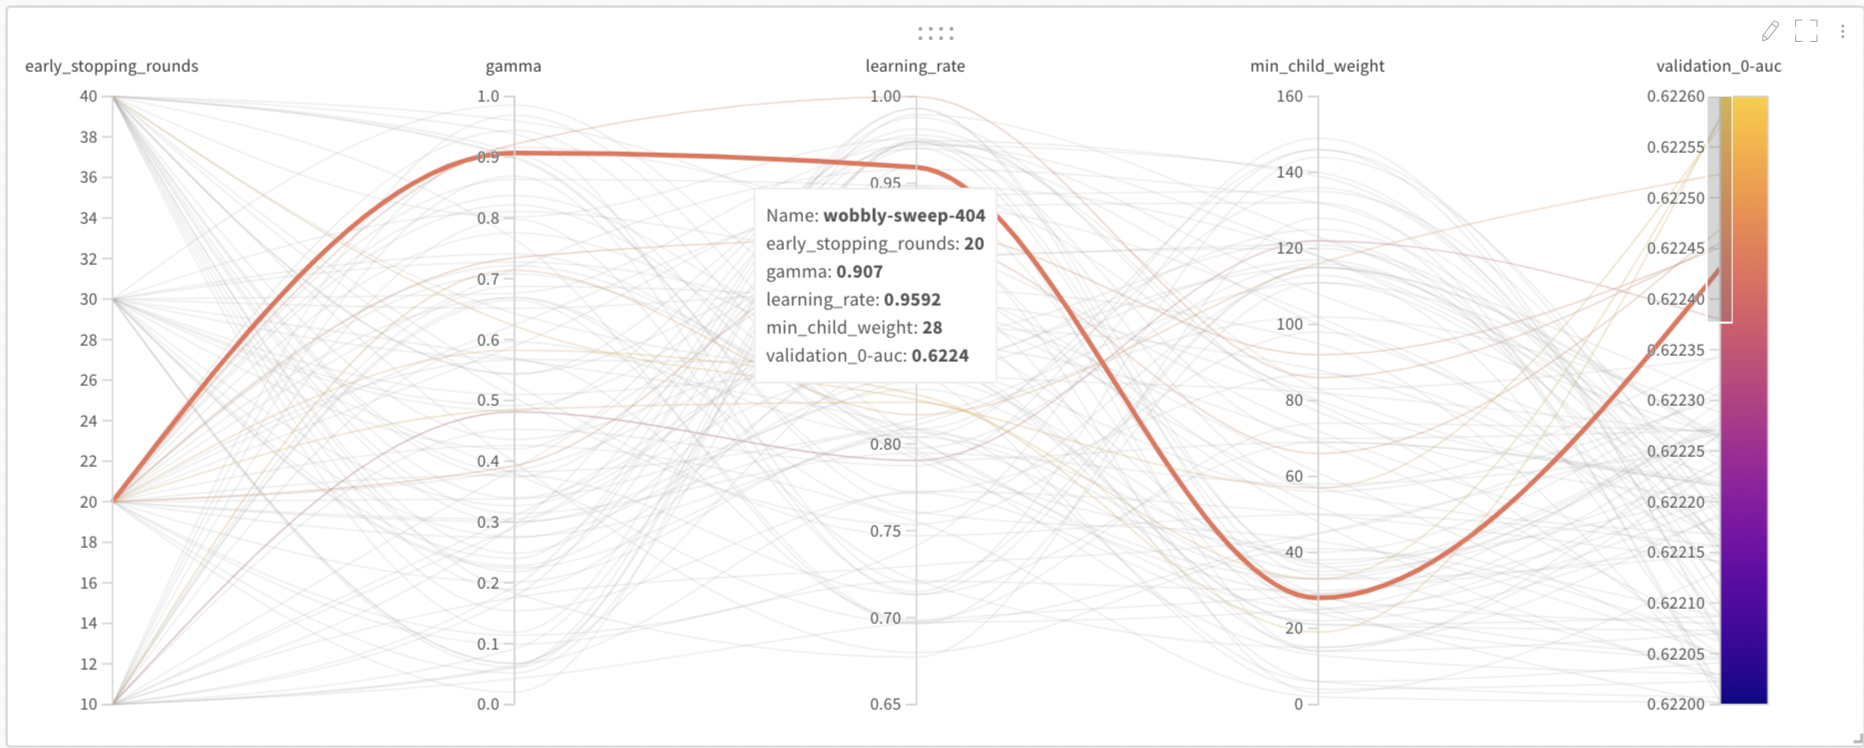

#### Define the Sweep Config
First we define the hyperparameters to sweep over as well as the type of sweep to use, we'll do a random search over the learning_rate, gamma, min_child_weights and easrly_stopping_rounds

In [18]:
sweep_configuration = {
  'method': 'bayes',
  'name': 'sweep',
  'metric': {
        'goal': 'maximize', 
        'name': 'val_acc_best_trh'
        },
  "parameters" : {
    "max_depth" :{
      "min": 3,
      "max": 10
    },
    "min_child_weight" :{
      "min": 1,
      "max": 10
    },
    "subsample" :{
      "min": 0.5,
      "max": 1.0
    },
    "colsample_bytree" :{
      "min": 0.5,
      "max": 1.0
    },
    "n_estimators":{
      'values': [30, 60, 90, 120, 150, 180, 210]
    },
    "learning_rate" :{
      "min": 0.001,
      "max": 1.0
    },
  }
}

sweep_id = wandb.sweep(sweep_configuration, project=WANDB_PROJECT)

Create sweep with ID: 6zycoh6c
Sweep URL: https://wandb.ai/max-deep/titanic_survived/sweeps/6zycoh6c


#### Define the Training Function

Then we define the function that will train our model using these hyperparameters. Note that `job_type='sweep'` when initialising the run, so that we can easily filter out these runs from our main workspace if we need to

In [19]:
def train():
    with wandb.init(job_type="sweep") as run:

        params = {'max_depth': run.config['max_depth'] ## default: 6
            , 'min_child_weight': run.config['min_child_weight']  ## default: 1
            , 'subsample': run.config['subsample'] ## default: 1
            , 'colsample_bytree': run.config['colsample_bytree'] ## default: 1
            , 'n_estimators': run.config['n_estimators'] ## default: 100
            , 'learning_rate': run.config['learning_rate'] ## default: 0.3
            , 'early_stopping_rounds': None ## optional
            , 'random_state': 42
            , 'tree_method': 'hist'
            , 'device': 'cuda' 
        }
        
        # Create pipeline
        pipeline = Pipeline([("preprocessor", preprocessor), # Preprocessing
                            ("classifier", xgb.XGBClassifier(**params,
                                    callbacks=[WandbCallback(log_model=True)])) # XGBoost classifier
                            ])
        
        # Perform cross-validation
        cv_scores = model_selection.cross_val_score(pipeline, X_train, y_train, cv=5, scoring='accuracy')

        # Fit the pipeline on the training data
        pipeline.fit(X_train, y_train)

        bstr = pipeline.named_steps['classifier'].get_booster()

        # Get train and validation predictions
        y_train_preds = pipeline.predict_proba(X_train)[:,1]
        y_val_preds = pipeline.predict_proba(X_val)[:,1]

        # Log additional Train metrics
        false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(y_train, y_train_preds)
        run.summary['train_ks_stat'] = max(true_positive_rate - false_positive_rate)
        run.summary['train_auc'] = metrics.auc(false_positive_rate, true_positive_rate)
        run.summary['train_log_loss'] = -(y_train * np.log(y_train_preds) + (1-y_train) * np.log(1-y_train_preds)).sum() / len(y_train)
        run.summary['mean_cv_accuracy'] =  np.mean(cv_scores)

        # Log additional Validation metrics
        fpr, tpr, thresholds = metrics.roc_curve(y_val, y_val_preds)
        optimal_idx = np.argmax(tpr - fpr)
        optimal_threshold = thresholds[optimal_idx]

        y_val_preds_binary = np.where(y_val_preds >= optimal_threshold, 1, 0)

        ks_stat, ks_pval = ks_2samp(y_val_preds[y_val==1], y_val_preds[y_val==0])
        run.summary["val_ks_2samp"] = ks_stat
        run.summary["val_ks_pval"] = ks_pval
        run.summary["val_auc"] = metrics.roc_auc_score(y_val, y_val_preds)
        run.summary["val_acc_0.5"] = metrics.accuracy_score(y_val, np.where(y_val_preds >= 0.5, 1, 0))
        run.summary[f"val_acc_best_trh"] = metrics.accuracy_score(y_val, y_val_preds_binary)
        run.summary["val_log_loss"] = -(y_val * np.log(y_val_preds)
                                            + (1-y_val) * np.log(1-y_val_preds)).sum() / len(y_val)

        


#### Run the Sweeps Agent

In [20]:
count = 100 # number of runs to execute
wandb.agent(sweep_id, function=train, count=count)

wandb: Agent Starting Run: vb8bglsu with config:
wandb: 	colsample_bytree: 0.6273986472917432
wandb: 	learning_rate: 0.04005619921185925
wandb: 	max_depth: 3
wandb: 	min_child_weight: 4
wandb: 	n_estimators: 150
wandb: 	subsample: 0.8983677642301183


epoch,▁▂▃▄▅▇█▁▃▄▅▆▇▁▂▃▄▅▆█▁▂▃▅▆▇█▂▃▄▅▆▇▁▂▃▄▆▇█
epoch,149
mean_cv_accuracy,0.81471
train_auc,0.9109
train_ks_stat,0.69652
train_log_loss,0.36107
val_acc_0.5,0.77095
val_acc_best_trh,0.81564
val_auc,0.83735
val_ks_2samp,0.62978
val_ks_pval,0.0


wandb: Agent Starting Run: 5ls3etez with config:
wandb: 	colsample_bytree: 0.7093466138800043
wandb: 	learning_rate: 0.5726972199509932
wandb: 	max_depth: 7
wandb: 	min_child_weight: 8
wandb: 	n_estimators: 90
wandb: 	subsample: 0.9630017883356852


epoch,▁▂▃▅▅▇█▁▃▄▅▆▇▁▂▃▄▅▆█▁▂▄▄▅▇█▁▃▄▅▆▇█▂▃▄▅▆█
epoch,89
mean_cv_accuracy,0.82592
train_auc,0.94986
train_ks_stat,0.77742
train_log_loss,0.28161
val_acc_0.5,0.82123
val_acc_best_trh,0.8324
val_auc,0.84177
val_ks_2samp,0.61383
val_ks_pval,0.0


wandb: Agent Starting Run: 094s90cm with config:
wandb: 	colsample_bytree: 0.5475462743343226
wandb: 	learning_rate: 0.29043571667125223
wandb: 	max_depth: 3
wandb: 	min_child_weight: 8
wandb: 	n_estimators: 210
wandb: 	subsample: 0.9844999263411224


epoch,▁▂▃▄▅▆█▁▂▄▅▆▇█▂▃▄▅▆▇▁▂▃▅▆▇█▂▃▄▅▆▇▁▂▃▄▅▇█
epoch,209
mean_cv_accuracy,0.82451
train_auc,0.94105
train_ks_stat,0.77425
train_log_loss,0.30234
val_acc_0.5,0.79888
val_acc_best_trh,0.81564
val_auc,0.84802
val_ks_2samp,0.58116
val_ks_pval,0.0


wandb: Agent Starting Run: t4itswv9 with config:
wandb: 	colsample_bytree: 0.7122405099547133
wandb: 	learning_rate: 0.44955744835508754
wandb: 	max_depth: 7
wandb: 	min_child_weight: 8
wandb: 	n_estimators: 90
wandb: 	subsample: 0.90846703453741


epoch,▁▂▃▅▅▇█▁▃▄▅▆▇▁▂▃▄▅▆█▁▂▄▄▅▇█▁▃▄▅▆▇█▂▃▄▅▆█
epoch,89
mean_cv_accuracy,0.82596
train_auc,0.9461
train_ks_stat,0.78474
train_log_loss,0.29336
val_acc_0.5,0.8324
val_acc_best_trh,0.83799
val_auc,0.83333
val_ks_2samp,0.63373
val_ks_pval,0.0


wandb: Agent Starting Run: v63xfoo5 with config:
wandb: 	colsample_bytree: 0.7572559412913555
wandb: 	learning_rate: 0.4359763321722376
wandb: 	max_depth: 9
wandb: 	min_child_weight: 10
wandb: 	n_estimators: 90
wandb: 	subsample: 0.8166914687967608


epoch,▁▂▃▅▅▇█▁▃▄▅▆▇▁▂▃▄▅▆█▁▂▄▄▅▇█▁▃▄▅▆▇█▂▃▄▅▆█
epoch,89
mean_cv_accuracy,0.8133
train_auc,0.93558
train_ks_stat,0.73494
train_log_loss,0.31515
val_acc_0.5,0.81564
val_acc_best_trh,0.84358
val_auc,0.85586
val_ks_2samp,0.62661
val_ks_pval,0.0


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 26wb6rx2 with config:
wandb: 	colsample_bytree: 0.7459434364979892
wandb: 	learning_rate: 0.2646231435390241
wandb: 	max_depth: 9
wandb: 	min_child_weight: 9
wandb: 	n_estimators: 30
wandb: 	subsample: 0.7647649110345458


epoch,▁▂▃▄▅▇▇▁▃▃▅▆▇█▁▃▄▅▇▇▁▂▃▅▅▇█▁▃▄▅▆▇▁▂▃▅▅▇█
epoch,29
mean_cv_accuracy,0.81048
train_auc,0.90231
train_ks_stat,0.66839
train_log_loss,0.37487
val_acc_0.5,0.82123
val_acc_best_trh,0.82682
val_auc,0.8471
val_ks_2samp,0.59934
val_ks_pval,0.0


wandb: Agent Starting Run: ybpzsb28 with config:
wandb: 	colsample_bytree: 0.694294483348657
wandb: 	learning_rate: 0.5926409556650635
wandb: 	max_depth: 10
wandb: 	min_child_weight: 10
wandb: 	n_estimators: 90
wandb: 	subsample: 0.7810732256262582


epoch,▁▂▃▅▅▇█▁▃▄▅▆▇▁▂▃▄▅▆█▁▂▄▄▅▇█▁▃▄▅▆▇█▂▃▄▅▆█
epoch,89
mean_cv_accuracy,0.81187
train_auc,0.93828
train_ks_stat,0.74673
train_log_loss,0.30665
val_acc_0.5,0.81564
val_acc_best_trh,0.84358
val_auc,0.84809
val_ks_2samp,0.61581
val_ks_pval,0.0


wandb: Agent Starting Run: 1db1euev with config:
wandb: 	colsample_bytree: 0.707979421632688
wandb: 	learning_rate: 0.4057154512830223
wandb: 	max_depth: 9
wandb: 	min_child_weight: 10
wandb: 	n_estimators: 150
wandb: 	subsample: 0.7936390645595006


epoch,▁▂▃▄▅▇█▁▃▄▅▆▇▁▂▃▄▅▆█▁▂▃▅▆▇█▂▃▄▅▆▇▁▂▃▄▆▇█
epoch,149
mean_cv_accuracy,0.82454
train_auc,0.94573
train_ks_stat,0.76504
train_log_loss,0.29832
val_acc_0.5,0.80447
val_acc_best_trh,0.82123
val_auc,0.84677
val_ks_2samp,0.62266
val_ks_pval,0.0


wandb: Agent Starting Run: satyhp4u with config:
wandb: 	colsample_bytree: 0.6287120107197551
wandb: 	learning_rate: 0.4788696821411351
wandb: 	max_depth: 10
wandb: 	min_child_weight: 9
wandb: 	n_estimators: 90
wandb: 	subsample: 0.8675450697615557


epoch,▁▂▃▅▅▇█▁▃▄▅▆▇▁▂▃▄▅▆█▁▂▄▄▅▇█▁▃▄▅▆▇█▂▃▄▅▆█
epoch,89
mean_cv_accuracy,0.82027
train_auc,0.94274
train_ks_stat,0.76326
train_log_loss,0.29851
val_acc_0.5,0.81006
val_acc_best_trh,0.82682
val_auc,0.84572
val_ks_2samp,0.60474
val_ks_pval,0.0


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: o6o3ulj6 with config:
wandb: 	colsample_bytree: 0.8042200293134832
wandb: 	learning_rate: 0.3935445131402817
wandb: 	max_depth: 10
wandb: 	min_child_weight: 9
wandb: 	n_estimators: 90
wandb: 	subsample: 0.8280702148122264


epoch,▁▂▃▅▅▇█▁▃▄▅▆▇▁▂▃▄▅▆█▁▂▄▄▅▇█▁▃▄▅▆▇█▂▃▄▅▆█
epoch,89
mean_cv_accuracy,0.82594
train_auc,0.94692
train_ks_stat,0.78336
train_log_loss,0.29308
val_acc_0.5,0.8324
val_acc_best_trh,0.83799
val_auc,0.85797
val_ks_2samp,0.63913
val_ks_pval,0.0


wandb: Agent Starting Run: m6ano457 with config:
wandb: 	colsample_bytree: 0.7947102406107733
wandb: 	learning_rate: 0.5496339389528659
wandb: 	max_depth: 10
wandb: 	min_child_weight: 9
wandb: 	n_estimators: 60
wandb: 	subsample: 0.8753292824137144


epoch,▁▂▃▄▅▇▇▁▃▃▅▆▇█▁▃▄▅▇▇▁▂▃▅▅▇█▁▃▄▅▆▇▁▂▃▅▅▇█
epoch,59
mean_cv_accuracy,0.81608
train_auc,0.94425
train_ks_stat,0.76732
train_log_loss,0.29663
val_acc_0.5,0.79888
val_acc_best_trh,0.82682
val_auc,0.82477
val_ks_2samp,0.58314
val_ks_pval,0.0


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 1dqminjq with config:
wandb: 	colsample_bytree: 0.7656595261511548
wandb: 	learning_rate: 0.389806095133684
wandb: 	max_depth: 7
wandb: 	min_child_weight: 8
wandb: 	n_estimators: 120
wandb: 	subsample: 0.8992086422954202


epoch,▁▂▃▄▅▇▇▁▃▃▅▆▇█▁▃▄▅▇▇▁▂▃▅▅▇█▁▃▄▅▆▇▁▂▃▅▅▇█
epoch,119
mean_cv_accuracy,0.83155
train_auc,0.95876
train_ks_stat,0.80493
train_log_loss,0.25902
val_acc_0.5,0.81564
val_acc_best_trh,0.84358
val_auc,0.84493
val_ks_2samp,0.63202
val_ks_pval,0.0


wandb: Agent Starting Run: puwreopo with config:
wandb: 	colsample_bytree: 0.8119946018359699
wandb: 	learning_rate: 0.24571131663636253
wandb: 	max_depth: 7
wandb: 	min_child_weight: 9
wandb: 	n_estimators: 150
wandb: 	subsample: 0.8200064691558605


epoch,▁▂▃▄▅▇█▁▃▄▅▆▇▁▂▃▄▅▆█▁▂▃▅▆▇█▂▃▄▅▆▇▁▂▃▄▆▇█
epoch,149
mean_cv_accuracy,0.82452
train_auc,0.94367
train_ks_stat,0.77049
train_log_loss,0.29778
val_acc_0.5,0.82682
val_acc_best_trh,0.82682
val_auc,0.84967
val_ks_2samp,0.63175
val_ks_pval,0.0


wandb: Agent Starting Run: ayq8bvnj with config:
wandb: 	colsample_bytree: 0.7760052912194374
wandb: 	learning_rate: 0.40128049751498623
wandb: 	max_depth: 8
wandb: 	min_child_weight: 10
wandb: 	n_estimators: 120
wandb: 	subsample: 0.8454266224230134


epoch,▁▂▃▄▅▇▇▁▃▃▅▆▇█▁▃▄▅▇▇▁▂▃▅▅▇█▁▃▄▅▆▇▁▂▃▅▅▇█
epoch,119
mean_cv_accuracy,0.82173
train_auc,0.94666
train_ks_stat,0.7696
train_log_loss,0.29206
val_acc_0.5,0.84916
val_acc_best_trh,0.84916
val_auc,0.8581
val_ks_2samp,0.66271
val_ks_pval,0.0


wandb: Agent Starting Run: mwbks8me with config:
wandb: 	colsample_bytree: 0.7307667973262901
wandb: 	learning_rate: 0.28759001399543443
wandb: 	max_depth: 8
wandb: 	min_child_weight: 10
wandb: 	n_estimators: 120
wandb: 	subsample: 0.878806377085001


epoch,▁▂▃▄▅▇▇▁▃▃▅▆▇█▁▃▄▅▇▇▁▂▃▅▅▇█▁▃▄▅▆▇▁▂▃▅▅▇█
epoch,119
mean_cv_accuracy,0.82173
train_auc,0.9379
train_ks_stat,0.74396
train_log_loss,0.31147
val_acc_0.5,0.81564
val_acc_best_trh,0.82123
val_auc,0.83867
val_ks_2samp,0.61186
val_ks_pval,0.0


wandb: Agent Starting Run: dc3iiqyp with config:
wandb: 	colsample_bytree: 0.8529614158239565
wandb: 	learning_rate: 0.002783100407446607
wandb: 	max_depth: 5
wandb: 	min_child_weight: 4
wandb: 	n_estimators: 120
wandb: 	subsample: 0.7333095093837492


epoch,▁▂▃▄▅▇▇▁▃▃▅▆▇█▁▃▄▅▇▇▁▂▃▅▅▇█▁▃▄▅▆▇▁▂▃▅▅▇█
epoch,119
mean_cv_accuracy,0.78937
train_auc,0.89258
train_ks_stat,0.65069
train_log_loss,0.56389
val_acc_0.5,0.77654
val_acc_best_trh,0.7933
val_auc,0.83406
val_ks_2samp,0.57181
val_ks_pval,0.0


wandb: Agent Starting Run: 1738lj5s with config:
wandb: 	colsample_bytree: 0.7802949199088733
wandb: 	learning_rate: 0.4516469612902387
wandb: 	max_depth: 7
wandb: 	min_child_weight: 9
wandb: 	n_estimators: 150
wandb: 	subsample: 0.8519599813893254


epoch,▁▂▃▄▅▇█▁▃▄▅▆▇▁▂▃▄▅▆█▁▂▃▅▆▇█▂▃▄▅▆▇▁▂▃▄▆▇█
epoch,149
mean_cv_accuracy,0.82731
train_auc,0.95816
train_ks_stat,0.80247
train_log_loss,0.25873
val_acc_0.5,0.8324
val_acc_best_trh,0.82682
val_auc,0.85751
val_ks_2samp,0.63175
val_ks_pval,0.0


wandb: Agent Starting Run: 7u1y7f7v with config:
wandb: 	colsample_bytree: 0.6386359181594892
wandb: 	learning_rate: 0.8174156718685474
wandb: 	max_depth: 3
wandb: 	min_child_weight: 1
wandb: 	n_estimators: 120
wandb: 	subsample: 0.7813006594773078


epoch,▁▂▃▄▅▇▇▁▃▃▅▆▇█▁▃▄▅▇▇▁▂▃▅▅▇█▁▃▄▅▆▇▁▂▃▅▅▇█
epoch,119
mean_cv_accuracy,0.79641
train_auc,0.98577
train_ks_stat,0.87653
train_log_loss,0.15769
val_acc_0.5,0.77654
val_acc_best_trh,0.81564
val_auc,0.83781
val_ks_2samp,0.56495
val_ks_pval,0.0


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 3stun3rc with config:
wandb: 	colsample_bytree: 0.7579194549312767
wandb: 	learning_rate: 0.5025109281715777
wandb: 	max_depth: 10
wandb: 	min_child_weight: 10
wandb: 	n_estimators: 120
wandb: 	subsample: 0.8350665413886422


epoch,▁▂▃▄▅▇▇▁▃▃▅▆▇█▁▃▄▅▇▇▁▂▃▅▅▇█▁▃▄▅▆▇▁▂▃▅▅▇█
epoch,119
mean_cv_accuracy,0.81889
train_auc,0.95204
train_ks_stat,0.78742
train_log_loss,0.27265
val_acc_0.5,0.83799
val_acc_best_trh,0.83799
val_auc,0.86107
val_ks_2samp,0.63913
val_ks_pval,0.0


wandb: Agent Starting Run: 2fcqq1y5 with config:
wandb: 	colsample_bytree: 0.771499512988475
wandb: 	learning_rate: 0.5937620588044865
wandb: 	max_depth: 9
wandb: 	min_child_weight: 10
wandb: 	n_estimators: 150
wandb: 	subsample: 0.8261216761132544


epoch,▁▂▃▄▅▇█▁▃▄▅▆▇▁▂▃▄▅▆█▁▂▃▅▆▇█▂▃▄▅▆▇▁▂▃▄▆▇█
epoch,149
mean_cv_accuracy,0.83013
train_auc,0.95908
train_ks_stat,0.80672
train_log_loss,0.25782
val_acc_0.5,0.82123
val_acc_best_trh,0.83799
val_auc,0.85264
val_ks_2samp,0.61752
val_ks_pval,0.0


wandb: Agent Starting Run: v6q9kj2t with config:
wandb: 	colsample_bytree: 0.7826556041208204
wandb: 	learning_rate: 0.514731443662801
wandb: 	max_depth: 10
wandb: 	min_child_weight: 10
wandb: 	n_estimators: 120
wandb: 	subsample: 0.8843058774723268


epoch,▁▂▃▄▅▇▇▁▃▃▅▆▇█▁▃▄▅▇▇▁▂▃▅▅▇█▁▃▄▅▆▇▁▂▃▅▅▇█
epoch,119
mean_cv_accuracy,0.8147
train_auc,0.94983
train_ks_stat,0.78059
train_log_loss,0.28185
val_acc_0.5,0.8324
val_acc_best_trh,0.83799
val_auc,0.84835
val_ks_2samp,0.63373
val_ks_pval,0.0


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: tv9cr06m with config:
wandb: 	colsample_bytree: 0.8077306032302379
wandb: 	learning_rate: 0.5962315397140885
wandb: 	max_depth: 10
wandb: 	min_child_weight: 10
wandb: 	n_estimators: 120
wandb: 	subsample: 0.7481333632746505


epoch,▁▂▃▄▅▇▇▁▃▃▅▆▇█▁▃▄▅▇▇▁▂▃▅▅▇█▁▃▄▅▆▇▁▂▃▅▅▇█
epoch,119
mean_cv_accuracy,0.83297
train_auc,0.94826
train_ks_stat,0.76683
train_log_loss,0.28277
val_acc_0.5,0.81564
val_acc_best_trh,0.83799
val_auc,0.84605
val_ks_2samp,0.62833
val_ks_pval,0.0


wandb: Agent Starting Run: ag9bhvep with config:
wandb: 	colsample_bytree: 0.9046779851927712
wandb: 	learning_rate: 0.488171355147808
wandb: 	max_depth: 9
wandb: 	min_child_weight: 10
wandb: 	n_estimators: 150
wandb: 	subsample: 0.7946935295870914


epoch,▁▂▃▄▅▇█▁▃▄▅▆▇▁▂▃▄▅▆█▁▂▃▅▆▇█▂▃▄▅▆▇▁▂▃▄▆▇█
epoch,149
mean_cv_accuracy,0.82027
train_auc,0.9542
train_ks_stat,0.77255
train_log_loss,0.27553
val_acc_0.5,0.81006
val_acc_best_trh,0.82682
val_auc,0.84295
val_ks_2samp,0.62095
val_ks_pval,0.0


wandb: Agent Starting Run: 6fegabtk with config:
wandb: 	colsample_bytree: 0.7723491092528505
wandb: 	learning_rate: 0.7423849082743764
wandb: 	max_depth: 8
wandb: 	min_child_weight: 9
wandb: 	n_estimators: 90
wandb: 	subsample: 0.867571402287802


epoch,▁▂▃▅▅▇█▁▃▄▅▆▇▁▂▃▄▅▆█▁▂▄▄▅▇█▁▃▄▅▆▇█▂▃▄▅▆█
epoch,89
mean_cv_accuracy,0.82592
train_auc,0.95841
train_ks_stat,0.80078
train_log_loss,0.26261
val_acc_0.5,0.82682
val_acc_best_trh,0.83799
val_auc,0.84934
val_ks_2samp,0.61752
val_ks_pval,0.0


wandb: Agent Starting Run: 6btsosf4 with config:
wandb: 	colsample_bytree: 0.7396498374027083
wandb: 	learning_rate: 0.44138157212041207
wandb: 	max_depth: 9
wandb: 	min_child_weight: 9
wandb: 	n_estimators: 120
wandb: 	subsample: 0.733248674675391


epoch,▁▂▃▄▅▇▇▁▃▃▅▆▇█▁▃▄▅▇▇▁▂▃▅▅▇█▁▃▄▅▆▇▁▂▃▅▅▇█
epoch,119
mean_cv_accuracy,0.82315
train_auc,0.94283
train_ks_stat,0.76187
train_log_loss,0.29238
val_acc_0.5,0.81006
val_acc_best_trh,0.81564
val_auc,0.84677
val_ks_2samp,0.60277
val_ks_pval,0.0


wandb: Agent Starting Run: 3n4z5wxt with config:
wandb: 	colsample_bytree: 0.7686242898882765
wandb: 	learning_rate: 0.6053827928435115
wandb: 	max_depth: 9
wandb: 	min_child_weight: 10
wandb: 	n_estimators: 150
wandb: 	subsample: 0.9444819335582126


epoch,▁▂▃▄▅▇█▁▃▄▅▆▇▁▂▃▄▅▆█▁▂▃▅▆▇█▂▃▄▅▆▇▁▂▃▄▆▇█
epoch,149
mean_cv_accuracy,0.81467
train_auc,0.95942
train_ks_stat,0.79511
train_log_loss,0.26123
val_acc_0.5,0.81564
val_acc_best_trh,0.82123
val_auc,0.84697
val_ks_2samp,0.60646
val_ks_pval,0.0


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: up3itmej with config:
wandb: 	colsample_bytree: 0.8165090783636499
wandb: 	learning_rate: 0.7858065158942662
wandb: 	max_depth: 9
wandb: 	min_child_weight: 10
wandb: 	n_estimators: 90
wandb: 	subsample: 0.8156706025652066


epoch,▁▂▃▅▅▇█▁▃▄▅▆▇▁▂▃▄▅▆█▁▂▄▄▅▇█▁▃▄▅▆▇█▂▃▄▅▆█
epoch,89
mean_cv_accuracy,0.82171
train_auc,0.95402
train_ks_stat,0.80038
train_log_loss,0.27199
val_acc_0.5,0.84358
val_acc_best_trh,0.84916
val_auc,0.86021
val_ks_2samp,0.6357
val_ks_pval,0.0


wandb: Agent Starting Run: fkrr3sdk with config:
wandb: 	colsample_bytree: 0.6986679301498053
wandb: 	learning_rate: 0.9438975714605036
wandb: 	max_depth: 10
wandb: 	min_child_weight: 9
wandb: 	n_estimators: 90
wandb: 	subsample: 0.8005099936950801


epoch,▁▂▃▅▅▇█▁▃▄▅▆▇▁▂▃▄▅▆█▁▂▄▄▅▇█▁▃▄▅▆▇█▂▃▄▅▆█
epoch,89
mean_cv_accuracy,0.82312
train_auc,0.94798
train_ks_stat,0.788
train_log_loss,0.2805
val_acc_0.5,0.80447
val_acc_best_trh,0.82682
val_auc,0.82727
val_ks_2samp,0.58854
val_ks_pval,0.0


wandb: Agent Starting Run: w277jg1l with config:
wandb: 	colsample_bytree: 0.8658928011881835
wandb: 	learning_rate: 0.5990581903409518
wandb: 	max_depth: 9
wandb: 	min_child_weight: 9
wandb: 	n_estimators: 120
wandb: 	subsample: 0.8281107478232479


epoch,▁▂▃▄▅▇▇▁▃▃▅▆▇█▁▃▄▅▇▇▁▂▃▅▅▇█▁▃▄▅▆▇▁▂▃▅▅▇█
epoch,119
mean_cv_accuracy,0.82595
train_auc,0.95743
train_ks_stat,0.8002
train_log_loss,0.25568
val_acc_0.5,0.82682
val_acc_best_trh,0.84916
val_auc,0.84256
val_ks_2samp,0.6357
val_ks_pval,0.0


wandb: Agent Starting Run: w3ujwlyu with config:
wandb: 	colsample_bytree: 0.8209162862677339
wandb: 	learning_rate: 0.6039289458260078
wandb: 	max_depth: 10
wandb: 	min_child_weight: 10
wandb: 	n_estimators: 90
wandb: 	subsample: 0.8586950466542993


epoch,▁▂▃▅▅▇█▁▃▄▅▆▇▁▂▃▄▅▆█▁▂▄▄▅▇█▁▃▄▅▆▇█▂▃▄▅▆█
epoch,89
mean_cv_accuracy,0.81467
train_auc,0.95216
train_ks_stat,0.78841
train_log_loss,0.27839
val_acc_0.5,0.81564
val_acc_best_trh,0.83799
val_auc,0.84513
val_ks_2samp,0.61212
val_ks_pval,0.0


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: y0u10xki with config:
wandb: 	colsample_bytree: 0.9489768192772516
wandb: 	learning_rate: 0.7345528547354133
wandb: 	max_depth: 9
wandb: 	min_child_weight: 8
wandb: 	n_estimators: 90
wandb: 	subsample: 0.8644921884384753


epoch,▁▂▃▅▅▇█▁▃▄▅▆▇▁▂▃▄▅▆█▁▂▄▄▅▇█▁▃▄▅▆▇█▂▃▄▅▆█
epoch,89
mean_cv_accuracy,0.82733
train_auc,0.96475
train_ks_stat,0.82553
train_log_loss,0.24129
val_acc_0.5,0.82123
val_acc_best_trh,0.8324
val_auc,0.83472
val_ks_2samp,0.61383
val_ks_pval,0.0


wandb: Agent Starting Run: g57ttyzo with config:
wandb: 	colsample_bytree: 0.8700672481620821
wandb: 	learning_rate: 0.5925085861389667
wandb: 	max_depth: 8
wandb: 	min_child_weight: 10
wandb: 	n_estimators: 150
wandb: 	subsample: 0.8754813049754271


epoch,▁▂▃▄▅▇█▁▃▄▅▆▇▁▂▃▄▅▆█▁▂▃▅▆▇█▂▃▄▅▆▇▁▂▃▄▆▇█
epoch,149
mean_cv_accuracy,0.82313
train_auc,0.96386
train_ks_stat,0.80029
train_log_loss,0.24918
val_acc_0.5,0.8324
val_acc_best_trh,0.8324
val_auc,0.85316
val_ks_2samp,0.63004
val_ks_pval,0.0


wandb: Agent Starting Run: bffqgunr with config:
wandb: 	colsample_bytree: 0.783890714437689
wandb: 	learning_rate: 0.7140477312379272
wandb: 	max_depth: 10
wandb: 	min_child_weight: 10
wandb: 	n_estimators: 90
wandb: 	subsample: 0.7551896813072063


epoch,▁▂▃▅▅▇█▁▃▄▅▆▇▁▂▃▄▅▆█▁▂▄▄▅▇█▁▃▄▅▆▇█▂▃▄▅▆█
epoch,89
mean_cv_accuracy,0.82171
train_auc,0.94746
train_ks_stat,0.75762
train_log_loss,0.29079
val_acc_0.5,0.8324
val_acc_best_trh,0.83799
val_auc,0.84908
val_ks_2samp,0.62292
val_ks_pval,0.0


wandb: Agent Starting Run: 2lhmtr18 with config:
wandb: 	colsample_bytree: 0.8053819858195183
wandb: 	learning_rate: 0.5630659339284604
wandb: 	max_depth: 8
wandb: 	min_child_weight: 10
wandb: 	n_estimators: 120
wandb: 	subsample: 0.8153576120410779


epoch,▁▂▃▄▅▇▇▁▃▃▅▆▇█▁▃▄▅▇▇▁▂▃▅▅▇█▁▃▄▅▆▇▁▂▃▅▅▇█
epoch,119
mean_cv_accuracy,0.82175
train_auc,0.95072
train_ks_stat,0.788
train_log_loss,0.27137
val_acc_0.5,0.8324
val_acc_best_trh,0.84916
val_auc,0.85487
val_ks_2samp,0.6357
val_ks_pval,0.0


wandb: Agent Starting Run: 8csh32fp with config:
wandb: 	colsample_bytree: 0.8702817553312187
wandb: 	learning_rate: 0.3930396627950052
wandb: 	max_depth: 8
wandb: 	min_child_weight: 10
wandb: 	n_estimators: 150
wandb: 	subsample: 0.8639160261688543


epoch,▁▂▃▄▅▇█▁▃▄▅▆▇▁▂▃▄▅▆█▁▂▃▅▆▇█▂▃▄▅▆▇▁▂▃▄▆▇█
epoch,149
mean_cv_accuracy,0.82589
train_auc,0.951
train_ks_stat,0.77425
train_log_loss,0.28237
val_acc_0.5,0.81564
val_acc_best_trh,0.8324
val_auc,0.84671
val_ks_2samp,0.61924
val_ks_pval,0.0


wandb: Agent Starting Run: 0nc0oa7u with config:
wandb: 	colsample_bytree: 0.93737808162549
wandb: 	learning_rate: 0.38734508455749256
wandb: 	max_depth: 8
wandb: 	min_child_weight: 9
wandb: 	n_estimators: 90
wandb: 	subsample: 0.9602764502999732


epoch,▁▂▃▅▅▇█▁▃▄▅▆▇▁▂▃▄▅▆█▁▂▄▄▅▇█▁▃▄▅▆▇█▂▃▄▅▆█
epoch,89
mean_cv_accuracy,0.81608
train_auc,0.9475
train_ks_stat,0.77554
train_log_loss,0.28998
val_acc_0.5,0.80447
val_acc_best_trh,0.81006
val_auc,0.83689
val_ks_2samp,0.60448
val_ks_pval,0.0


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: a01k7zgy with config:
wandb: 	colsample_bytree: 0.7990817907363625
wandb: 	learning_rate: 0.6401978948883686
wandb: 	max_depth: 9
wandb: 	min_child_weight: 10
wandb: 	n_estimators: 120
wandb: 	subsample: 0.7615979658651628


epoch,▁▂▃▄▅▇▇▁▃▃▅▆▇█▁▃▄▅▇▇▁▂▃▅▅▇█▁▃▄▅▆▇▁▂▃▅▅▇█
epoch,119
mean_cv_accuracy,0.82315
train_auc,0.95207
train_ks_stat,0.77585
train_log_loss,0.27144
val_acc_0.5,0.81564
val_acc_best_trh,0.85475
val_auc,0.84941
val_ks_2samp,0.6502
val_ks_pval,0.0


wandb: Agent Starting Run: th145a0f with config:
wandb: 	colsample_bytree: 0.8857211965913581
wandb: 	learning_rate: 0.6208657518713003
wandb: 	max_depth: 8
wandb: 	min_child_weight: 10
wandb: 	n_estimators: 120
wandb: 	subsample: 0.7843479683498575


epoch,▁▂▃▄▅▇▇▁▃▃▅▆▇█▁▃▄▅▇▇▁▂▃▅▅▇█▁▃▄▅▆▇▁▂▃▅▅▇█
epoch,119
mean_cv_accuracy,0.80627
train_auc,0.95278
train_ks_stat,0.7809
train_log_loss,0.26978
val_acc_0.5,0.8324
val_acc_best_trh,0.85475
val_auc,0.85876
val_ks_2samp,0.661
val_ks_pval,0.0


wandb: Agent Starting Run: l8nddbff with config:
wandb: 	colsample_bytree: 0.9376222405255884
wandb: 	learning_rate: 0.9343644521549488
wandb: 	max_depth: 8
wandb: 	min_child_weight: 9
wandb: 	n_estimators: 150
wandb: 	subsample: 0.7471329716416685


epoch,▁▂▃▄▅▇█▁▃▄▅▆▇▁▂▃▄▅▆█▁▂▃▅▆▇█▂▃▄▅▆▇▁▂▃▄▆▇█
epoch,149
mean_cv_accuracy,0.80342
train_auc,0.96673
train_ks_stat,0.81762
train_log_loss,0.22919
val_acc_0.5,0.82123
val_acc_best_trh,0.82123
val_auc,0.82931
val_ks_2samp,0.61186
val_ks_pval,0.0


wandb: Agent Starting Run: 45cyw9c8 with config:
wandb: 	colsample_bytree: 0.8412182451120596
wandb: 	learning_rate: 0.7911019543353848
wandb: 	max_depth: 9
wandb: 	min_child_weight: 9
wandb: 	n_estimators: 120
wandb: 	subsample: 0.7931366106729993


epoch,▁▂▃▄▅▇▇▁▃▃▅▆▇█▁▃▄▅▇▇▁▂▃▅▅▇█▁▃▄▅▆▇▁▂▃▅▅▇█
epoch,119
mean_cv_accuracy,0.82592
train_auc,0.95868
train_ks_stat,0.7981
train_log_loss,0.25438
val_acc_0.5,0.81564
val_acc_best_trh,0.82123
val_auc,0.8365
val_ks_2samp,0.60646
val_ks_pval,0.0


wandb: Agent Starting Run: run9erpf with config:
wandb: 	colsample_bytree: 0.9666558149986308
wandb: 	learning_rate: 0.5941572493324768
wandb: 	max_depth: 9
wandb: 	min_child_weight: 10
wandb: 	n_estimators: 120
wandb: 	subsample: 0.7373773264690502


epoch,▁▂▃▄▅▇▇▁▃▃▅▆▇█▁▃▄▅▇▇▁▂▃▅▅▇█▁▃▄▅▆▇▁▂▃▅▅▇█
epoch,119
mean_cv_accuracy,0.83156
train_auc,0.94702
train_ks_stat,0.76978
train_log_loss,0.2809
val_acc_0.5,0.79888
val_acc_best_trh,0.84916
val_auc,0.8475
val_ks_2samp,0.6303
val_ks_pval,0.0


wandb: Agent Starting Run: 7gz0kzdj with config:
wandb: 	colsample_bytree: 0.7377529757274554
wandb: 	learning_rate: 0.4508629156659327
wandb: 	max_depth: 8
wandb: 	min_child_weight: 10
wandb: 	n_estimators: 90
wandb: 	subsample: 0.8472423730746992


epoch,▁▂▃▅▅▇█▁▃▄▅▆▇▁▂▃▄▅▆█▁▂▄▄▅▇█▁▃▄▅▆▇█▂▃▄▅▆█
epoch,89
mean_cv_accuracy,0.81607
train_auc,0.94664
train_ks_stat,0.77009
train_log_loss,0.29327
val_acc_0.5,0.80447
val_acc_best_trh,0.84358
val_auc,0.85244
val_ks_2samp,0.63202
val_ks_pval,0.0


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 7sdq657o with config:
wandb: 	colsample_bytree: 0.9888329198998256
wandb: 	learning_rate: 0.4109858231086297
wandb: 	max_depth: 9
wandb: 	min_child_weight: 10
wandb: 	n_estimators: 120
wandb: 	subsample: 0.5938399453612354


epoch,▁▂▃▄▅▇▇▁▃▃▅▆▇█▁▃▄▅▇▇▁▂▃▅▅▇█▁▃▄▅▆▇▁▂▃▅▅▇█
epoch,119
mean_cv_accuracy,0.82031
train_auc,0.935
train_ks_stat,0.73109
train_log_loss,0.31821
val_acc_0.5,0.81564
val_acc_best_trh,0.7933
val_auc,0.84499
val_ks_2samp,0.59341
val_ks_pval,0.0


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 15j000of with config:
wandb: 	colsample_bytree: 0.8393239292243271
wandb: 	learning_rate: 0.7464451116223325
wandb: 	max_depth: 9
wandb: 	min_child_weight: 10
wandb: 	n_estimators: 60
wandb: 	subsample: 0.7113332982500375


epoch,▁▂▃▄▅▇▇▁▃▃▅▆▇█▁▃▄▅▇▇▁▂▃▅▅▇█▁▃▄▅▆▇▁▂▃▅▅▇█
epoch,59
mean_cv_accuracy,0.81328
train_auc,0.93783
train_ks_stat,0.72971
train_log_loss,0.309
val_acc_0.5,0.82123
val_acc_best_trh,0.83799
val_auc,0.83722
val_ks_2samp,0.61752
val_ks_pval,0.0


wandb: Agent Starting Run: 7a7ejjhc with config:
wandb: 	colsample_bytree: 0.8287333261485481
wandb: 	learning_rate: 0.6761257890986802
wandb: 	max_depth: 7
wandb: 	min_child_weight: 10
wandb: 	n_estimators: 60
wandb: 	subsample: 0.7931790070167726


epoch,▁▂▃▄▅▇▇▁▃▃▅▆▇█▁▃▄▅▇▇▁▂▃▅▅▇█▁▃▄▅▆▇▁▂▃▅▅▇█
epoch,59
mean_cv_accuracy,0.82031
train_auc,0.93917
train_ks_stat,0.75079
train_log_loss,0.30502
val_acc_0.5,0.81564
val_acc_best_trh,0.82682
val_auc,0.83623
val_ks_2samp,0.63175
val_ks_pval,0.0


wandb: Agent Starting Run: 8tqzyv21 with config:
wandb: 	colsample_bytree: 0.9526565184059924
wandb: 	learning_rate: 0.6019531605360815
wandb: 	max_depth: 8
wandb: 	min_child_weight: 10
wandb: 	n_estimators: 120
wandb: 	subsample: 0.8210892560874156


epoch,▁▂▃▄▅▇▇▁▃▃▅▆▇█▁▃▄▅▇▇▁▂▃▅▅▇█▁▃▄▅▆▇▁▂▃▅▅▇█
epoch,119
mean_cv_accuracy,0.82453
train_auc,0.9547
train_ks_stat,0.77692
train_log_loss,0.26666
val_acc_0.5,0.82682
val_acc_best_trh,0.8324
val_auc,0.85296
val_ks_2samp,0.63004
val_ks_pval,0.0


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: u46gisr5 with config:
wandb: 	colsample_bytree: 0.8645884191818856
wandb: 	learning_rate: 0.8695112388617259
wandb: 	max_depth: 10
wandb: 	min_child_weight: 10
wandb: 	n_estimators: 60
wandb: 	subsample: 0.869840741442742


epoch,▁▂▃▄▅▇▇▁▃▃▅▆▇█▁▃▄▅▇▇▁▂▃▅▅▇█▁▃▄▅▆▇▁▂▃▅▅▇█
epoch,59
mean_cv_accuracy,0.83152
train_auc,0.94865
train_ks_stat,0.78604
train_log_loss,0.28335
val_acc_0.5,0.8324
val_acc_best_trh,0.83799
val_auc,0.83096
val_ks_2samp,0.63373
val_ks_pval,0.0


wandb: Agent Starting Run: hesart9r with config:
wandb: 	colsample_bytree: 0.6787919188457603
wandb: 	learning_rate: 0.7772155120916328
wandb: 	max_depth: 10
wandb: 	min_child_weight: 10
wandb: 	n_estimators: 90
wandb: 	subsample: 0.6579630658771944


epoch,▁▂▃▅▅▇█▁▃▄▅▆▇▁▂▃▄▅▆█▁▂▄▄▅▇█▁▃▄▅▆▇█▂▃▄▅▆█
epoch,89
mean_cv_accuracy,0.80627
train_auc,0.93188
train_ks_stat,0.73404
train_log_loss,0.31925
val_acc_0.5,0.81564
val_acc_best_trh,0.81006
val_auc,0.83458
val_ks_2samp,0.61528
val_ks_pval,0.0


wandb: Agent Starting Run: y0nze1f5 with config:
wandb: 	colsample_bytree: 0.8684316847014815
wandb: 	learning_rate: 0.4788149264170273
wandb: 	max_depth: 9
wandb: 	min_child_weight: 8
wandb: 	n_estimators: 90
wandb: 	subsample: 0.7721007955090429


epoch,▁▂▃▅▅▇█▁▃▄▅▆▇▁▂▃▄▅▆█▁▂▄▄▅▇█▁▃▄▅▆▇█▂▃▄▅▆█
epoch,89
mean_cv_accuracy,0.82872
train_auc,0.95713
train_ks_stat,0.79444
train_log_loss,0.26659
val_acc_0.5,0.82123
val_acc_best_trh,0.8324
val_auc,0.84901
val_ks_2samp,0.60843
val_ks_pval,0.0


wandb: Agent Starting Run: sla5z9b8 with config:
wandb: 	colsample_bytree: 0.8689343105614352
wandb: 	learning_rate: 0.6176113135566121
wandb: 	max_depth: 8
wandb: 	min_child_weight: 9
wandb: 	n_estimators: 120
wandb: 	subsample: 0.7160752215816034


epoch,▁▂▃▄▅▇▇▁▃▃▅▆▇█▁▃▄▅▇▇▁▂▃▅▅▇█▁▃▄▅▆▇▁▂▃▅▅▇█
epoch,119
mean_cv_accuracy,0.82317
train_auc,0.95405
train_ks_stat,0.7792
train_log_loss,0.26764
val_acc_0.5,0.80447
val_acc_best_trh,0.82123
val_auc,0.85125
val_ks_2samp,0.58485
val_ks_pval,0.0


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: f97hxglb with config:
wandb: 	colsample_bytree: 0.7011519558119687
wandb: 	learning_rate: 0.28672159115196066
wandb: 	max_depth: 7
wandb: 	min_child_weight: 7
wandb: 	n_estimators: 120
wandb: 	subsample: 0.8985355517721595


epoch,▁▂▃▄▅▇▇▁▃▃▅▆▇█▁▃▄▅▇▇▁▂▃▅▅▇█▁▃▄▅▆▇▁▂▃▅▅▇█
epoch,119
mean_cv_accuracy,0.81325
train_auc,0.95084
train_ks_stat,0.79158
train_log_loss,0.28025
val_acc_0.5,0.81006
val_acc_best_trh,0.81006
val_auc,0.84071
val_ks_2samp,0.57747
val_ks_pval,0.0


wandb: Agent Starting Run: bv96duhk with config:
wandb: 	colsample_bytree: 0.9234655594407828
wandb: 	learning_rate: 0.6030206746652108
wandb: 	max_depth: 9
wandb: 	min_child_weight: 9
wandb: 	n_estimators: 150
wandb: 	subsample: 0.8334745491818683


epoch,▁▂▃▄▅▇█▁▃▄▅▆▇▁▂▃▄▅▆█▁▂▃▅▆▇█▂▃▄▅▆▇▁▂▃▄▆▇█
epoch,149
mean_cv_accuracy,0.83576
train_auc,0.96434
train_ks_stat,0.81552
train_log_loss,0.2436
val_acc_0.5,0.81564
val_acc_best_trh,0.82682
val_auc,0.83149
val_ks_2samp,0.61555
val_ks_pval,0.0


wandb: Agent Starting Run: o7v19lsw with config:
wandb: 	colsample_bytree: 0.8340842153404666
wandb: 	learning_rate: 0.3068549535473274
wandb: 	max_depth: 8
wandb: 	min_child_weight: 10
wandb: 	n_estimators: 120
wandb: 	subsample: 0.8479255658313565


epoch,▁▂▃▄▅▇▇▁▃▃▅▆▇█▁▃▄▅▇▇▁▂▃▅▅▇█▁▃▄▅▆▇▁▂▃▅▅▇█
epoch,119
mean_cv_accuracy,0.82173
train_auc,0.93775
train_ks_stat,0.73891
train_log_loss,0.3121
val_acc_0.5,0.82123
val_acc_best_trh,0.8324
val_auc,0.86594
val_ks_2samp,0.64625
val_ks_pval,0.0


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 90iqhctq with config:
wandb: 	colsample_bytree: 0.8028706502600182
wandb: 	learning_rate: 0.5389982952215333
wandb: 	max_depth: 10
wandb: 	min_child_weight: 10
wandb: 	n_estimators: 120
wandb: 	subsample: 0.7622209111998777


epoch,▁▂▃▄▅▇▇▁▃▃▅▆▇█▁▃▄▅▇▇▁▂▃▅▅▇█▁▃▄▅▆▇▁▂▃▅▅▇█
epoch,119
mean_cv_accuracy,0.81468
train_auc,0.94697
train_ks_stat,0.77652
train_log_loss,0.28413
val_acc_0.5,0.81564
val_acc_best_trh,0.84916
val_auc,0.84401
val_ks_2samp,0.64111
val_ks_pval,0.0


wandb: Agent Starting Run: vbwcx7l6 with config:
wandb: 	colsample_bytree: 0.5279435072287515
wandb: 	learning_rate: 0.14867038293683532
wandb: 	max_depth: 4
wandb: 	min_child_weight: 7
wandb: 	n_estimators: 210
wandb: 	subsample: 0.8985404946142559


epoch,▁▂▃▄▅▆█▁▂▄▅▆▇█▂▃▄▅▆▇▁▂▃▅▆▇█▂▃▄▅▆▇▁▂▃▄▅▇█
epoch,209
mean_cv_accuracy,0.81185
train_auc,0.93971
train_ks_stat,0.76455
train_log_loss,0.30841
val_acc_0.5,0.81564
val_acc_best_trh,0.81564
val_auc,0.84466
val_ks_2samp,0.58656
val_ks_pval,0.0


wandb: Agent Starting Run: k8g8xz6g with config:
wandb: 	colsample_bytree: 0.7837802497328102
wandb: 	learning_rate: 0.5561659687930836
wandb: 	max_depth: 8
wandb: 	min_child_weight: 10
wandb: 	n_estimators: 120
wandb: 	subsample: 0.8550202176633661


epoch,▁▂▃▄▅▇▇▁▃▃▅▆▇█▁▃▄▅▇▇▁▂▃▅▅▇█▁▃▄▅▆▇▁▂▃▅▅▇█
epoch,119
mean_cv_accuracy,0.83016
train_auc,0.9527
train_ks_stat,0.78434
train_log_loss,0.27192
val_acc_0.5,0.82123
val_acc_best_trh,0.82123
val_auc,0.86126
val_ks_2samp,0.61186
val_ks_pval,0.0


wandb: Agent Starting Run: b2mbq9a9 with config:
wandb: 	colsample_bytree: 0.5866601534179574
wandb: 	learning_rate: 0.31777850260070584
wandb: 	max_depth: 6
wandb: 	min_child_weight: 6
wandb: 	n_estimators: 210
wandb: 	subsample: 0.5914935641141569


epoch,▁▂▃▄▅▆█▁▂▄▅▆▇█▂▃▄▅▆▇▁▂▃▅▆▇█▂▃▄▅▆▇▁▂▃▄▅▇█
epoch,209
mean_cv_accuracy,0.82596
train_auc,0.959
train_ks_stat,0.80404
train_log_loss,0.25785
val_acc_0.5,0.81006
val_acc_best_trh,0.82123
val_auc,0.85152
val_ks_2samp,0.59565
val_ks_pval,0.0


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: dhwtrvu1 with config:
wandb: 	colsample_bytree: 0.7635467676905441
wandb: 	learning_rate: 0.008641915907411094
wandb: 	max_depth: 7
wandb: 	min_child_weight: 2
wandb: 	n_estimators: 150
wandb: 	subsample: 0.5005345900104771


epoch,▁▂▃▄▅▇█▁▃▄▅▆▇▁▂▃▄▅▆█▁▂▃▅▆▇█▂▃▄▅▆▇▁▂▃▄▆▇█
epoch,149
mean_cv_accuracy,0.80205
train_auc,0.91842
train_ks_stat,0.70831
train_log_loss,0.42328
val_acc_0.5,0.80447
val_acc_best_trh,0.79888
val_auc,0.83142
val_ks_2samp,0.5971
val_ks_pval,0.0


wandb: Agent Starting Run: qaiz16y4 with config:
wandb: 	colsample_bytree: 0.7290067046190104
wandb: 	learning_rate: 0.8315332262929258
wandb: 	max_depth: 6
wandb: 	min_child_weight: 4
wandb: 	n_estimators: 60
wandb: 	subsample: 0.9246316502332776


epoch,▁▂▃▄▅▇▇▁▃▃▅▆▇█▁▃▄▅▇▇▁▂▃▅▅▇█▁▃▄▅▆▇▁▂▃▅▅▇█
epoch,59
mean_cv_accuracy,0.81464
train_auc,0.98418
train_ks_stat,0.87346
train_log_loss,0.17662
val_acc_0.5,0.78771
val_acc_best_trh,0.77095
val_auc,0.83452
val_ks_2samp,0.56785
val_ks_pval,0.0


wandb: Agent Starting Run: luy8m01p with config:
wandb: 	colsample_bytree: 0.5081492005972421
wandb: 	learning_rate: 0.5686234734108218
wandb: 	max_depth: 6
wandb: 	min_child_weight: 2
wandb: 	n_estimators: 90
wandb: 	subsample: 0.6821900176484672


epoch,▁▂▃▅▅▇█▁▃▄▅▆▇▁▂▃▄▅▆█▁▂▄▄▅▇█▁▃▄▅▆▇█▂▃▄▅▆█
epoch,89
mean_cv_accuracy,0.81746
train_auc,0.97964
train_ks_stat,0.8492
train_log_loss,0.19379
val_acc_0.5,0.81564
val_acc_best_trh,0.82682
val_auc,0.83057
val_ks_2samp,0.62635
val_ks_pval,0.0


wandb: Agent Starting Run: rtl75a29 with config:
wandb: 	colsample_bytree: 0.8575029499018466
wandb: 	learning_rate: 0.4196199260902071
wandb: 	max_depth: 9
wandb: 	min_child_weight: 2
wandb: 	n_estimators: 150
wandb: 	subsample: 0.5272145966233663


epoch,▁▂▃▄▅▇█▁▃▄▅▆▇▁▂▃▄▅▆█▁▂▃▅▆▇█▂▃▄▅▆▇▁▂▃▄▆▇█
epoch,149
mean_cv_accuracy,0.80763
train_auc,0.98961
train_ks_stat,0.91504
train_log_loss,0.14808
val_acc_0.5,0.77654
val_acc_best_trh,0.78212
val_auc,0.83024
val_ks_2samp,0.56443
val_ks_pval,0.0


wandb: Agent Starting Run: 5uhknjbu with config:
wandb: 	colsample_bytree: 0.7671610472728095
wandb: 	learning_rate: 0.904561586343563
wandb: 	max_depth: 10
wandb: 	min_child_weight: 10
wandb: 	n_estimators: 90
wandb: 	subsample: 0.9004484590858783


epoch,▁▂▃▅▅▇█▁▃▄▅▆▇▁▂▃▄▅▆█▁▂▄▄▅▇█▁▃▄▅▆▇█▂▃▄▅▆█
epoch,89
mean_cv_accuracy,0.83153
train_auc,0.95919
train_ks_stat,0.79939
train_log_loss,0.25783
val_acc_0.5,0.7933
val_acc_best_trh,0.81564
val_auc,0.84183
val_ks_2samp,0.59196
val_ks_pval,0.0


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ipvvuete with config:
wandb: 	colsample_bytree: 0.7386596982532243
wandb: 	learning_rate: 0.6331286313349931
wandb: 	max_depth: 8
wandb: 	min_child_weight: 9
wandb: 	n_estimators: 90
wandb: 	subsample: 0.8240263983333653


epoch,▁▂▃▅▅▇█▁▃▄▅▆▇▁▂▃▄▅▆█▁▂▄▄▅▇█▁▃▄▅▆▇█▂▃▄▅▆█
epoch,89
mean_cv_accuracy,0.81751
train_auc,0.95569
train_ks_stat,0.77652
train_log_loss,0.27071
val_acc_0.5,0.79888
val_acc_best_trh,0.85475
val_auc,0.8392
val_ks_2samp,0.63939
val_ks_pval,0.0


wandb: Agent Starting Run: nmrrtpp0 with config:
wandb: 	colsample_bytree: 0.8815130903849373
wandb: 	learning_rate: 0.5309656159596777
wandb: 	max_depth: 10
wandb: 	min_child_weight: 10
wandb: 	n_estimators: 120
wandb: 	subsample: 0.7266203753947454


epoch,▁▂▃▄▅▇▇▁▃▃▅▆▇█▁▃▄▅▇▇▁▂▃▅▅▇█▁▃▄▅▆▇▁▂▃▅▅▇█
epoch,119
mean_cv_accuracy,0.81893
train_auc,0.94813
train_ks_stat,0.7688
train_log_loss,0.28225
val_acc_0.5,0.82123
val_acc_best_trh,0.83799
val_auc,0.84677
val_ks_2samp,0.61752
val_ks_pval,0.0


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: k04057lb with config:
wandb: 	colsample_bytree: 0.7021472987852995
wandb: 	learning_rate: 0.48576322583438675
wandb: 	max_depth: 8
wandb: 	min_child_weight: 10
wandb: 	n_estimators: 120
wandb: 	subsample: 0.7829872778736227


epoch,▁▂▃▄▅▇▇▁▃▃▅▆▇█▁▃▄▅▇▇▁▂▃▅▅▇█▁▃▄▅▆▇▁▂▃▅▅▇█
epoch,119
mean_cv_accuracy,0.81329
train_auc,0.94271
train_ks_stat,0.75633
train_log_loss,0.29709
val_acc_0.5,0.82123
val_acc_best_trh,0.83799
val_auc,0.85191
val_ks_2samp,0.61212
val_ks_pval,0.0


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: eap1svjg with config:
wandb: 	colsample_bytree: 0.7264926263494238
wandb: 	learning_rate: 0.4987391516935156
wandb: 	max_depth: 9
wandb: 	min_child_weight: 8
wandb: 	n_estimators: 90
wandb: 	subsample: 0.8046181647171955


epoch,▁▂▃▅▅▇█▁▃▄▅▆▇▁▂▃▄▅▆█▁▂▄▄▅▇█▁▃▄▅▆▇█▂▃▄▅▆█
epoch,89
mean_cv_accuracy,0.81471
train_auc,0.95237
train_ks_stat,0.7901
train_log_loss,0.27541
val_acc_0.5,0.81006
val_acc_best_trh,0.82682
val_auc,0.839
val_ks_2samp,0.59394
val_ks_pval,0.0


wandb: Agent Starting Run: 4ra8s254 with config:
wandb: 	colsample_bytree: 0.912756917782268
wandb: 	learning_rate: 0.5251152443193458
wandb: 	max_depth: 9
wandb: 	min_child_weight: 10
wandb: 	n_estimators: 90
wandb: 	subsample: 0.7443615450764445


epoch,▁▂▃▅▅▇█▁▃▄▅▆▇▁▂▃▄▅▆█▁▂▄▄▅▇█▁▃▄▅▆▇█▂▃▄▅▆█
epoch,89
mean_cv_accuracy,0.83156
train_auc,0.94447
train_ks_stat,0.74485
train_log_loss,0.29747
val_acc_0.5,0.80447
val_acc_best_trh,0.84358
val_auc,0.85178
val_ks_2samp,0.62121
val_ks_pval,0.0


wandb: Agent Starting Run: axdje6w0 with config:
wandb: 	colsample_bytree: 0.9429023033121336
wandb: 	learning_rate: 0.6923682233391033
wandb: 	max_depth: 9
wandb: 	min_child_weight: 10
wandb: 	n_estimators: 60
wandb: 	subsample: 0.7932653828633061


epoch,▁▂▃▄▅▇▇▁▃▃▅▆▇█▁▃▄▅▇▇▁▂▃▅▅▇█▁▃▄▅▆▇▁▂▃▅▅▇█
epoch,59
mean_cv_accuracy,0.80627
train_auc,0.94254
train_ks_stat,0.749
train_log_loss,0.29776
val_acc_0.5,0.82682
val_acc_best_trh,0.84916
val_auc,0.86298
val_ks_2samp,0.6303
val_ks_pval,0.0


wandb: Agent Starting Run: uwstvrhk with config:
wandb: 	colsample_bytree: 0.6384649585718302
wandb: 	learning_rate: 0.6213934879743479
wandb: 	max_depth: 9
wandb: 	min_child_weight: 10
wandb: 	n_estimators: 90
wandb: 	subsample: 0.8497695409925909
Timed out waiting for wandb service to start after 30.0 seconds. Try increasing the timeout with the `_service_wait` setting.
Traceback (most recent call last):
  File "c:\Users\Maxpo\Documents\GitHub\tabular-data-prediction-pipeline\.venv\lib\site-packages\wandb\sdk\wandb_init.py", line 1166, in init
    wi.setup(kwargs)
  File "c:\Users\Maxpo\Documents\GitHub\tabular-data-prediction-pipeline\.venv\lib\site-packages\wandb\sdk\wandb_init.py", line 191, in setup
    self._wl = wandb_setup.setup(settings=setup_settings)
  File "c:\Users\Maxpo\Documents\GitHub\tabular-data-prediction-pipeline\.venv\lib\site-packages\wandb\sdk\wandb_setup.py", line 327, in setup
    ret = _setup(settings=settings)
  File "c:\Users\Maxpo\Documents\GitHub\tabular-

epoch,▁▂▃▅▅▇█▁▃▄▅▆▇▁▂▃▄▅▆█▁▂▄▄▅▇█▁▃▄▅▆▇█▂▃▄▅▆█
epoch,89
mean_cv_accuracy,0.82174
train_auc,0.94525
train_ks_stat,0.78246
train_log_loss,0.2933
val_acc_0.5,0.82682
val_acc_best_trh,0.84358
val_auc,0.84223
val_ks_2samp,0.62661
val_ks_pval,0.0


wandb: Agent Starting Run: p830pf5j with config:
wandb: 	colsample_bytree: 0.7157223851799536
wandb: 	learning_rate: 0.6111659688226546
wandb: 	max_depth: 8
wandb: 	min_child_weight: 10
wandb: 	n_estimators: 60
wandb: 	subsample: 0.815485774847754


epoch,▁▂▃▄▅▇▇▁▃▃▅▆▇█▁▃▄▅▇▇▁▂▃▅▅▇█▁▃▄▅▆▇▁▂▃▅▅▇█
epoch,59
mean_cv_accuracy,0.81468
train_auc,0.94152
train_ks_stat,0.73293
train_log_loss,0.30472
val_acc_0.5,0.81006
val_acc_best_trh,0.83799
val_auc,0.84776
val_ks_2samp,0.60672
val_ks_pval,0.0


wandb: Agent Starting Run: 0t5w9by8 with config:
wandb: 	colsample_bytree: 0.951055978184995
wandb: 	learning_rate: 0.5719738326080347
wandb: 	max_depth: 10
wandb: 	min_child_weight: 10
wandb: 	n_estimators: 60
wandb: 	subsample: 0.7671444701576717


epoch,▁▂▃▄▅▇▇▁▃▃▅▆▇█▁▃▄▅▇▇▁▂▃▅▅▇█▁▃▄▅▆▇▁▂▃▅▅▇█
epoch,59
mean_cv_accuracy,0.81894
train_auc,0.93471
train_ks_stat,0.74762
train_log_loss,0.31225
val_acc_0.5,0.84358
val_acc_best_trh,0.84358
val_auc,0.84012
val_ks_2samp,0.63202
val_ks_pval,0.0


wandb: Agent Starting Run: t3mvloby with config:
wandb: 	colsample_bytree: 0.9895705321569108
wandb: 	learning_rate: 0.6997243193030793
wandb: 	max_depth: 10
wandb: 	min_child_weight: 10
wandb: 	n_estimators: 60
wandb: 	subsample: 0.8652848268397355


epoch,▁▂▃▄▅▇▇▁▃▃▅▆▇█▁▃▄▅▇▇▁▂▃▅▅▇█▁▃▄▅▆▇▁▂▃▅▅▇█
epoch,59
mean_cv_accuracy,0.81745
train_auc,0.94307
train_ks_stat,0.76098
train_log_loss,0.30135
val_acc_0.5,0.81006
val_acc_best_trh,0.82123
val_auc,0.85158
val_ks_2samp,0.60646
val_ks_pval,0.0


wandb: Agent Starting Run: hl1yq1yr with config:
wandb: 	colsample_bytree: 0.8081782783887304
wandb: 	learning_rate: 0.6675549067142414
wandb: 	max_depth: 10
wandb: 	min_child_weight: 10
wandb: 	n_estimators: 90
wandb: 	subsample: 0.7506021561049876


epoch,▁▂▃▅▅▇█▁▃▄▅▆▇▁▂▃▄▅▆█▁▂▄▄▅▇█▁▃▄▅▆▇█▂▃▄▅▆█
epoch,89
mean_cv_accuracy,0.82877
train_auc,0.94869
train_ks_stat,0.77197
train_log_loss,0.28914
val_acc_0.5,0.81006
val_acc_best_trh,0.84358
val_auc,0.82997
val_ks_2samp,0.62121
val_ks_pval,0.0


wandb: Agent Starting Run: kfpmzekt with config:
wandb: 	colsample_bytree: 0.6331988858550557
wandb: 	learning_rate: 0.6717428155184243
wandb: 	max_depth: 7
wandb: 	min_child_weight: 10
wandb: 	n_estimators: 90
wandb: 	subsample: 0.8720657977128272


epoch,▁▂▃▅▅▇█▁▃▄▅▆▇▁▂▃▄▅▆█▁▂▄▄▅▇█▁▃▄▅▆▇█▂▃▄▅▆█
epoch,89
mean_cv_accuracy,0.82172
train_auc,0.9438
train_ks_stat,0.77
train_log_loss,0.29757
val_acc_0.5,0.82682
val_acc_best_trh,0.84358
val_auc,0.85534
val_ks_2samp,0.63202
val_ks_pval,0.0


wandb: Agent Starting Run: ygqxgp4b with config:
wandb: 	colsample_bytree: 0.8742839472751363
wandb: 	learning_rate: 0.9201397108441616
wandb: 	max_depth: 10
wandb: 	min_child_weight: 10
wandb: 	n_estimators: 60
wandb: 	subsample: 0.7250938563068797


epoch,▁▂▃▄▅▇▇▁▃▃▅▆▇█▁▃▄▅▇▇▁▂▃▅▅▇█▁▃▄▅▆▇▁▂▃▅▅▇█
epoch,59
mean_cv_accuracy,0.82735
train_auc,0.9373
train_ks_stat,0.73463
train_log_loss,0.30667
val_acc_0.5,0.81564
val_acc_best_trh,0.82682
val_auc,0.83235
val_ks_2samp,0.59394
val_ks_pval,0.0


wandb: Agent Starting Run: tn4r4zcp with config:
wandb: 	colsample_bytree: 0.8517134331316845
wandb: 	learning_rate: 0.6562006955020389
wandb: 	max_depth: 9
wandb: 	min_child_weight: 10
wandb: 	n_estimators: 90
wandb: 	subsample: 0.7720482647885303


epoch,▁▂▃▅▅▇█▁▃▄▅▆▇▁▂▃▄▅▆█▁▂▄▄▅▇█▁▃▄▅▆▇█▂▃▄▅▆█
epoch,89
mean_cv_accuracy,0.81891
train_auc,0.94864
train_ks_stat,0.7792
train_log_loss,0.28474
val_acc_0.5,0.8324
val_acc_best_trh,0.83799
val_auc,0.84895
val_ks_2samp,0.62833
val_ks_pval,0.0


wandb: Agent Starting Run: pjx85v8q with config:
wandb: 	colsample_bytree: 0.8614226904779885
wandb: 	learning_rate: 0.5107134898270455
wandb: 	max_depth: 10
wandb: 	min_child_weight: 10
wandb: 	n_estimators: 90
wandb: 	subsample: 0.7843352300351742


epoch,▁▂▃▅▅▇█▁▃▄▅▆▇▁▂▃▄▅▆█▁▂▄▄▅▇█▁▃▄▅▆▇█▂▃▄▅▆█
epoch,89
mean_cv_accuracy,0.82874
train_auc,0.94074
train_ks_stat,0.75218
train_log_loss,0.30149
val_acc_0.5,0.83799
val_acc_best_trh,0.84358
val_auc,0.85033
val_ks_2samp,0.62661
val_ks_pval,0.0


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: r0vbe6tz with config:
wandb: 	colsample_bytree: 0.682899951272355
wandb: 	learning_rate: 0.8567399323867742
wandb: 	max_depth: 8
wandb: 	min_child_weight: 9
wandb: 	n_estimators: 90
wandb: 	subsample: 0.7970634393994571


epoch,▁▂▃▅▅▇█▁▃▄▅▆▇▁▂▃▄▅▆█▁▂▄▄▅▇█▁▃▄▅▆▇█▂▃▄▅▆█
epoch,89
mean_cv_accuracy,0.81612
train_auc,0.94965
train_ks_stat,0.78197
train_log_loss,0.27541
val_acc_0.5,0.78212
val_acc_best_trh,0.8324
val_auc,0.82984
val_ks_2samp,0.60303
val_ks_pval,0.0


wandb: Agent Starting Run: 2xzb7axb with config:
wandb: 	colsample_bytree: 0.6371308474689761
wandb: 	learning_rate: 0.6647728766027222
wandb: 	max_depth: 7
wandb: 	min_child_weight: 10
wandb: 	n_estimators: 90
wandb: 	subsample: 0.8448562218921235


epoch,▁▂▃▅▅▇█▁▃▄▅▆▇▁▂▃▄▅▆█▁▂▄▄▅▇█▁▃▄▅▆▇█▂▃▄▅▆█
epoch,89
mean_cv_accuracy,0.80906
train_auc,0.94687
train_ks_stat,0.77098
train_log_loss,0.28769
val_acc_0.5,0.81564
val_acc_best_trh,0.8324
val_auc,0.84796
val_ks_2samp,0.62464
val_ks_pval,0.0


wandb: Agent Starting Run: ggaywopv with config:
wandb: 	colsample_bytree: 0.6310253781960218
wandb: 	learning_rate: 0.7433472714013287
wandb: 	max_depth: 8
wandb: 	min_child_weight: 10
wandb: 	n_estimators: 120
wandb: 	subsample: 0.9862031753912434


epoch,▁▂▃▄▅▇▇▁▃▃▅▆▇█▁▃▄▅▇▇▁▂▃▅▅▇█▁▃▄▅▆▇▁▂▃▅▅▇█
epoch,119
mean_cv_accuracy,0.82314
train_auc,0.94732
train_ks_stat,0.76938
train_log_loss,0.28793
val_acc_0.5,0.80447
val_acc_best_trh,0.81006
val_auc,0.84038
val_ks_2samp,0.60448
val_ks_pval,0.0


wandb: Agent Starting Run: oeneyslq with config:
wandb: 	colsample_bytree: 0.9078035437667608
wandb: 	learning_rate: 0.6528698213878741
wandb: 	max_depth: 10
wandb: 	min_child_weight: 10
wandb: 	n_estimators: 60
wandb: 	subsample: 0.8117286473034218


epoch,▁▂▃▄▅▇▇▁▃▃▅▆▇█▁▃▄▅▇▇▁▂▃▅▅▇█▁▃▄▅▆▇▁▂▃▅▅▇█
epoch,59
mean_cv_accuracy,0.82029
train_auc,0.94317
train_ks_stat,0.7575
train_log_loss,0.30137
val_acc_0.5,0.82682
val_acc_best_trh,0.84358
val_auc,0.84704
val_ks_2samp,0.62661
val_ks_pval,0.0


wandb: Agent Starting Run: b7kl0cls with config:
wandb: 	colsample_bytree: 0.8047378092722848
wandb: 	learning_rate: 0.4258328541334344
wandb: 	max_depth: 8
wandb: 	min_child_weight: 9
wandb: 	n_estimators: 90
wandb: 	subsample: 0.830091631806485


epoch,▁▂▃▅▅▇█▁▃▄▅▆▇▁▂▃▄▅▆█▁▂▄▄▅▇█▁▃▄▅▆▇█▂▃▄▅▆█
epoch,89
mean_cv_accuracy,0.81888
train_auc,0.94788
train_ks_stat,0.77791
train_log_loss,0.29424
val_acc_0.5,0.81564
val_acc_best_trh,0.82123
val_auc,0.85593
val_ks_2samp,0.61726
val_ks_pval,0.0


wandb: Agent Starting Run: vdrr4m1x with config:
wandb: 	colsample_bytree: 0.6172213495012602
wandb: 	learning_rate: 0.7876795398299029
wandb: 	max_depth: 6
wandb: 	min_child_weight: 10
wandb: 	n_estimators: 60
wandb: 	subsample: 0.8589608978409508


epoch,▁▂▃▄▅▇▇▁▃▃▅▆▇█▁▃▄▅▇▇▁▂▃▅▅▇█▁▃▄▅▆▇▁▂▃▅▅▇█
epoch,59
mean_cv_accuracy,0.80901
train_auc,0.93523
train_ks_stat,0.73007
train_log_loss,0.31251
val_acc_0.5,0.79888
val_acc_best_trh,0.80447
val_auc,0.83702
val_ks_2samp,0.56838
val_ks_pval,0.0


wandb: Agent Starting Run: jrpji0lk with config:
wandb: 	colsample_bytree: 0.7245400486021217
wandb: 	learning_rate: 0.6073763983247438
wandb: 	max_depth: 10
wandb: 	min_child_weight: 10
wandb: 	n_estimators: 120
wandb: 	subsample: 0.756161911897405


epoch,▁▂▃▄▅▇▇▁▃▃▅▆▇█▁▃▄▅▇▇▁▂▃▅▅▇█▁▃▄▅▆▇▁▂▃▅▅▇█
epoch,119
mean_cv_accuracy,0.81889
train_auc,0.94817
train_ks_stat,0.77523
train_log_loss,0.28118
val_acc_0.5,0.80447
val_acc_best_trh,0.8324
val_auc,0.84736
val_ks_2samp,0.61924
val_ks_pval,0.0


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: wrojhnj2 with config:
wandb: 	colsample_bytree: 0.6640808759908163
wandb: 	learning_rate: 0.6113250240464756
wandb: 	max_depth: 8
wandb: 	min_child_weight: 8
wandb: 	n_estimators: 120
wandb: 	subsample: 0.8557900250643107


epoch,▁▂▃▄▅▇▇▁▃▃▅▆▇█▁▃▄▅▇▇▁▂▃▅▅▇█▁▃▄▅▆▇▁▂▃▅▅▇█
epoch,119
mean_cv_accuracy,0.82457
train_auc,0.9566
train_ks_stat,0.80583
train_log_loss,0.25928
val_acc_0.5,0.81564
val_acc_best_trh,0.8324
val_auc,0.84822
val_ks_2samp,0.61383
val_ks_pval,0.0


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: rqj7jsxh with config:
wandb: 	colsample_bytree: 0.9413812680656516
wandb: 	learning_rate: 0.781894070064803
wandb: 	max_depth: 10
wandb: 	min_child_weight: 9
wandb: 	n_estimators: 60
wandb: 	subsample: 0.7655605160050832


epoch,▁▂▃▄▅▇▇▁▃▃▅▆▇█▁▃▄▅▇▇▁▂▃▅▅▇█▁▃▄▅▆▇▁▂▃▅▅▇█
epoch,59
mean_cv_accuracy,0.81471
train_auc,0.95327
train_ks_stat,0.77939
train_log_loss,0.28334
val_acc_0.5,0.83799
val_acc_best_trh,0.84358
val_auc,0.84526
val_ks_2samp,0.62661
val_ks_pval,0.0


wandb: Agent Starting Run: hqc5qu4l with config:
wandb: 	colsample_bytree: 0.9573209444671676
wandb: 	learning_rate: 0.6951308205575037
wandb: 	max_depth: 9
wandb: 	min_child_weight: 10
wandb: 	n_estimators: 150
wandb: 	subsample: 0.768217984100288


epoch,▁▂▃▄▅▇█▁▃▄▅▆▇▁▂▃▄▅▆█▁▂▃▅▆▇█▂▃▄▅▆▇▁▂▃▄▆▇█
epoch,149
mean_cv_accuracy,0.82311
train_auc,0.95862
train_ks_stat,0.78881
train_log_loss,0.2564
val_acc_0.5,0.82123
val_acc_best_trh,0.83799
val_auc,0.84486
val_ks_2samp,0.61752
val_ks_pval,0.0


wandb: Agent Starting Run: qsddsaw8 with config:
wandb: 	colsample_bytree: 0.7984542762408746
wandb: 	learning_rate: 0.6623510320004894
wandb: 	max_depth: 8
wandb: 	min_child_weight: 10
wandb: 	n_estimators: 90
wandb: 	subsample: 0.8015176122955734


epoch,▁▂▃▅▅▇█▁▃▄▅▆▇▁▂▃▄▅▆█▁▂▄▄▅▇█▁▃▄▅▆▇█▂▃▄▅▆█
epoch,89
mean_cv_accuracy,0.8217
train_auc,0.95089
train_ks_stat,0.75969
train_log_loss,0.28489
val_acc_0.5,0.80447
val_acc_best_trh,0.83799
val_auc,0.84084
val_ks_2samp,0.62292
val_ks_pval,0.0


wandb: Agent Starting Run: 4lm2le0r with config:
wandb: 	colsample_bytree: 0.9721147717179656
wandb: 	learning_rate: 0.7435858413808984
wandb: 	max_depth: 10
wandb: 	min_child_weight: 10
wandb: 	n_estimators: 60
wandb: 	subsample: 0.7011340498494306


epoch,▁▂▃▄▅▇▇▁▃▃▅▆▇█▁▃▄▅▇▇▁▂▃▅▅▇█▁▃▄▅▆▇▁▂▃▅▅▇█
epoch,59
mean_cv_accuracy,0.82312
train_auc,0.93496
train_ks_stat,0.75178
train_log_loss,0.30886
val_acc_0.5,0.81564
val_acc_best_trh,0.82123
val_auc,0.83814
val_ks_2samp,0.57945
val_ks_pval,0.0


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 3s55yzk2 with config:
wandb: 	colsample_bytree: 0.9934755612258908
wandb: 	learning_rate: 0.6606535321697234
wandb: 	max_depth: 3
wandb: 	min_child_weight: 8
wandb: 	n_estimators: 30
wandb: 	subsample: 0.549222213039269


epoch,▁▂▃▄▅▇▇▁▃▃▅▆▇█▁▃▄▅▇▇▁▂▃▅▅▇█▁▃▄▅▆▇▁▂▃▅▅▇█
epoch,29
mean_cv_accuracy,0.8049
train_auc,0.91857
train_ks_stat,0.69514
train_log_loss,0.35203
val_acc_0.5,0.77095
val_acc_best_trh,0.81006
val_auc,0.80988
val_ks_2samp,0.53966
val_ks_pval,0.0


wandb: Agent Starting Run: n4prstc4 with config:
wandb: 	colsample_bytree: 0.923504842092684
wandb: 	learning_rate: 0.5845273375178796
wandb: 	max_depth: 10
wandb: 	min_child_weight: 9
wandb: 	n_estimators: 90
wandb: 	subsample: 0.7988567604518124


epoch,▁▂▃▅▅▇█▁▃▄▅▆▇▁▂▃▄▅▆█▁▂▄▄▅▇█▁▃▄▅▆▇█▂▃▄▅▆█
epoch,89
mean_cv_accuracy,0.83298
train_auc,0.95351
train_ks_stat,0.79622
train_log_loss,0.28178
val_acc_0.5,0.82682
val_acc_best_trh,0.84916
val_auc,0.86357
val_ks_2samp,0.6303
val_ks_pval,0.0


wandb: Agent Starting Run: b455r1jy with config:
wandb: 	colsample_bytree: 0.9145868635724188
wandb: 	learning_rate: 0.4823283869793642
wandb: 	max_depth: 9
wandb: 	min_child_weight: 10
wandb: 	n_estimators: 30
wandb: 	subsample: 0.7388106463049158


epoch,▁▂▃▄▅▇▇▁▃▃▅▆▇█▁▃▄▅▇▇▁▂▃▅▅▇█▁▃▄▅▆▇▁▂▃▅▅▇█
epoch,29
mean_cv_accuracy,0.80627
train_auc,0.9165
train_ks_stat,0.70215
train_log_loss,0.35214
val_acc_0.5,0.7933
val_acc_best_trh,0.79888
val_auc,0.84368
val_ks_2samp,0.5917
val_ks_pval,0.0


wandb: Agent Starting Run: ifn962jr with config:
wandb: 	colsample_bytree: 0.7731174489279722
wandb: 	learning_rate: 0.46679805557335674
wandb: 	max_depth: 7
wandb: 	min_child_weight: 9
wandb: 	n_estimators: 120
wandb: 	subsample: 0.8610149254546461


epoch,▁▂▃▄▅▇▇▁▃▃▅▆▇█▁▃▄▅▇▇▁▂▃▅▅▇█▁▃▄▅▆▇▁▂▃▅▅▇█
epoch,119
mean_cv_accuracy,0.82873
train_auc,0.95393
train_ks_stat,0.79305
train_log_loss,0.26945
val_acc_0.5,0.8324
val_acc_best_trh,0.8324
val_auc,0.85224
val_ks_2samp,0.63544
val_ks_pval,0.0


wandb: Agent Starting Run: h2vly6pu with config:
wandb: 	colsample_bytree: 0.8082496894216145
wandb: 	learning_rate: 0.5326192104202423
wandb: 	max_depth: 10
wandb: 	min_child_weight: 9
wandb: 	n_estimators: 150
wandb: 	subsample: 0.8276764680046305


epoch,▁▂▃▄▅▇█▁▃▄▅▆▇▁▂▃▄▅▆█▁▂▃▅▆▇█▂▃▄▅▆▇▁▂▃▄▆▇█
epoch,149
mean_cv_accuracy,0.82877
train_auc,0.96105
train_ks_stat,0.81137
train_log_loss,0.2525
val_acc_0.5,0.81006
val_acc_best_trh,0.81564
val_auc,0.83511
val_ks_2samp,0.58656
val_ks_pval,0.0


wandb: Agent Starting Run: 7h0mbd8n with config:
wandb: 	colsample_bytree: 0.7877749696736004
wandb: 	learning_rate: 0.768822588906534
wandb: 	max_depth: 10
wandb: 	min_child_weight: 9
wandb: 	n_estimators: 90
wandb: 	subsample: 0.7834136649438557


epoch,▁▂▃▅▅▇█▁▃▄▅▆▇▁▂▃▄▅▆█▁▂▄▄▅▇█▁▃▄▅▆▇█▂▃▄▅▆█
epoch,89
mean_cv_accuracy,0.83016
train_auc,0.95365
train_ks_stat,0.79564
train_log_loss,0.26691
val_acc_0.5,0.82682
val_acc_best_trh,0.8324
val_auc,0.83445
val_ks_2samp,0.62464
val_ks_pval,0.0


wandb: Agent Starting Run: 2l3ibjby with config:
wandb: 	colsample_bytree: 0.7135624039299635
wandb: 	learning_rate: 0.4463236494305408
wandb: 	max_depth: 8
wandb: 	min_child_weight: 10
wandb: 	n_estimators: 120
wandb: 	subsample: 0.7965077735390756


epoch,▁▂▃▄▅▇▇▁▃▃▅▆▇█▁▃▄▅▇▇▁▂▃▅▅▇█▁▃▄▅▆▇▁▂▃▅▅▇█
epoch,119
mean_cv_accuracy,0.82594
train_auc,0.9411
train_ks_stat,0.75535
train_log_loss,0.29831
val_acc_0.5,0.81564
val_acc_best_trh,0.8324
val_auc,0.86337
val_ks_2samp,0.61924
val_ks_pval,0.0


wandb: Agent Starting Run: dni0p8dl with config:
wandb: 	colsample_bytree: 0.6728132323526625
wandb: 	learning_rate: 0.4609565842794117
wandb: 	max_depth: 7
wandb: 	min_child_weight: 10
wandb: 	n_estimators: 60
wandb: 	subsample: 0.837506479732844


epoch,▁▂▃▄▅▇▇▁▃▃▅▆▇█▁▃▄▅▇▇▁▂▃▅▅▇█▁▃▄▅▆▇▁▂▃▅▅▇█
epoch,59
mean_cv_accuracy,0.80487
train_auc,0.93155
train_ks_stat,0.74445
train_log_loss,0.32133
val_acc_0.5,0.81006
val_acc_best_trh,0.83799
val_auc,0.85296
val_ks_2samp,0.60672
val_ks_pval,0.0


wandb: Agent Starting Run: 2ipu4lo2 with config:
wandb: 	colsample_bytree: 0.8868652081810273
wandb: 	learning_rate: 0.665816808280413
wandb: 	max_depth: 10
wandb: 	min_child_weight: 9
wandb: 	n_estimators: 60
wandb: 	subsample: 0.7881637502413787


epoch,▁▂▃▄▅▇▇▁▃▃▅▆▇█▁▃▄▅▇▇▁▂▃▅▅▇█▁▃▄▅▆▇▁▂▃▅▅▇█
epoch,59
mean_cv_accuracy,0.8133
train_auc,0.9442
train_ks_stat,0.7788
train_log_loss,0.29113
val_acc_0.5,0.82682
val_acc_best_trh,0.8324
val_auc,0.8552
val_ks_2samp,0.62464
val_ks_pval,0.0


wandb: Agent Starting Run: x9d43tnr with config:
wandb: 	colsample_bytree: 0.9372488599535576
wandb: 	learning_rate: 0.7615852672710105
wandb: 	max_depth: 10
wandb: 	min_child_weight: 10
wandb: 	n_estimators: 150
wandb: 	subsample: 0.7598445841841153


epoch,▁▂▃▄▅▇█▁▃▄▅▆▇▁▂▃▄▅▆█▁▂▃▅▆▇█▂▃▄▅▆▇▁▂▃▄▆▇█
epoch,149
mean_cv_accuracy,0.82175
train_auc,0.95871
train_ks_stat,0.79515
train_log_loss,0.25505
val_acc_0.5,0.82123
val_acc_best_trh,0.82123
val_auc,0.84657
val_ks_2samp,0.60105
val_ks_pval,0.0


In [21]:
run.finish()

## W&B already in your favorite ML library

Weights and Biases has integrations in all of your favourite ML and Deep Learning libraries such as:

- Pytorch Lightning
- Keras
- Hugging Face
- JAX
- Fastai
- XGBoost
- Sci-Kit Learn
- LightGBM

**See [W&B integrations for details](https://docs.wandb.ai/guides/integrations)**